### 10X GENOMICS
<p style="text-align:center;">
<img src="figures/rnaseq_library.png" alt="bioinformatics_databases" width="1028" class="center"/>
</p>

In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import anndata as ad
import scipy as sp

plt.rcParams["figure.figsize"] = (40,20)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)
sc.set_figure_params(dpi_save=300)

In [16]:
data_cov1 = sc.read_h5ad('../data/GSE149689/nCoV_PBMC_1.h5ad')
data_cov15 = sc.read_h5ad('../data/GSE149689/nCoV_PBMC_15.h5ad')
data_cov17 = sc.read_h5ad('../data/GSE149689/nCoV_PBMC_17.h5ad')
data_ctrl5 = sc.read_h5ad('../data/GSE149689/Normal_PBMC_5.h5ad')
data_ctrl13 = sc.read_h5ad('../data/GSE149689/Normal_PBMC_13.h5ad')
data_ctrl14 = sc.read_h5ad('../data/GSE149689/Normal_PBMC_14.h5ad')

In [17]:
# add some metadata
data_cov1.obs['type']="covid"
data_cov1.obs['sample']="covid_1"
data_cov15.obs['type']="covid"
data_cov15.obs['sample']="covid_15"
data_cov17.obs['type']="covid"
data_cov17.obs['sample']="covid_17"
data_ctrl5.obs['type']="ctrl"
data_ctrl5.obs['sample']="ctrl_5"
data_ctrl13.obs['type']="ctrl"
data_ctrl13.obs['sample']="ctrl_13"
data_ctrl14.obs['type']="ctrl"
data_ctrl14.obs['sample']="ctrl_14"

# merge into one object.
adata = data_cov1.concatenate(data_cov15, data_cov17, data_ctrl5, data_ctrl13, data_ctrl14)

# and delete individual datasets to save space
del(data_cov1, data_cov15, data_cov17)
del(data_ctrl5, data_ctrl13, data_ctrl14)

In [18]:
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

<p style="text-align:center;">
<img src="figures/anndata.png" alt="bioinformatics_databases" width="400" class="center"/>
</p>

Anndata is a Python package and datastructure for handling annotated data matrices in memory and on disk (github.com/theislab/anndata), positioned between pandas and xarray. anndata offers a broad range of computationally efficient features including, among others, sparse data support, lazy operations, and a machine learning interface.

For instance, in scRNA-seq data, each row corresponds to a cell with a barcode, and each column corresponds to a gene with a gene id.

<p>
[3] <cite>anndata: Annotated data.</cite> Isaac Virshup, Sergei Rybakov, Fabian J. Theis, Philipp Angerer, F. Alexander Wolf, bioRxiv 2021.12.16.473007; doi: https://doi.org/10.1101/2021.12.16.473007</p>

In [19]:
adata.obs_names[:10].tolist()

['AGGGTCCCATGACCCG-1-0',
 'TACCCACAGCGGGTTA-1-0',
 'CCCAACTTCATATGGC-1-0',
 'TCAAGTGTCCGAACGC-1-0',
 'ATTCCTAGTGACTGTT-1-0',
 'GTGTTCCGTGGGCTCT-1-0',
 'CCTAAGACAGATTAAG-1-0',
 'AATAGAGAGGGTTAGC-1-0',
 'GGGTCACTCACCTACC-1-0',
 'TCCTCTTGTACAGTCT-1-0']

In [20]:
print(adata.var_names[:10].tolist())

['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1']


In [21]:
print(adata.X.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## QC AGAIN

Having the data in a suitable format, we can start calculating some quality metrics. We can for example calculate the percentage of mitocondrial and ribosomal genes per cell and add to the metadata. This will be helpfull to visualize them across different metadata parameteres (i.e. datasetID and chemistry version). There are several ways of doing this, and here manually calculate the proportion of mitochondrial reads and add to the metadata table.

High mitochondrial and ribosomal proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016; Lun, McCarthy & Marioni, 2017), because loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [22]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

gene_ids    feature_types  genome     mt   ribo     hb
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False
...                      ...              ...     ...    ...    ...    ...
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False  False  False
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False  False  False
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False  False  False
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False  False  False
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False  False  False

[33538 rows x 6 columns]

In [23]:
import scanpy as sc

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

... storing 'type' as categorical
... storing 'sample' as categorical


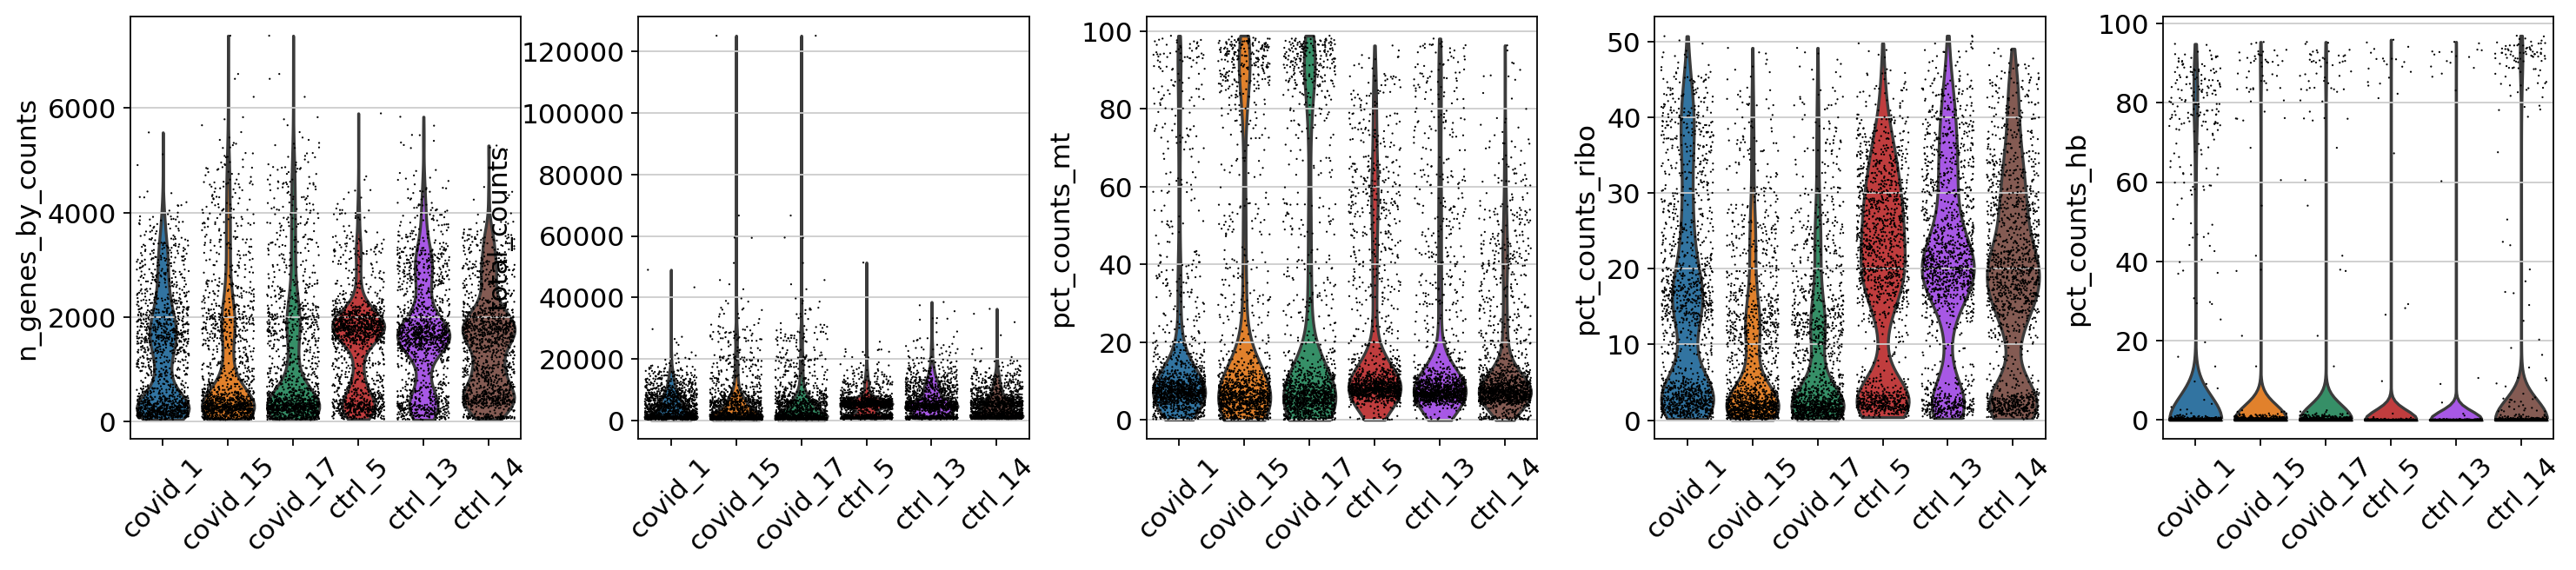

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

Text(100000, 20.65, '$\\tau$')

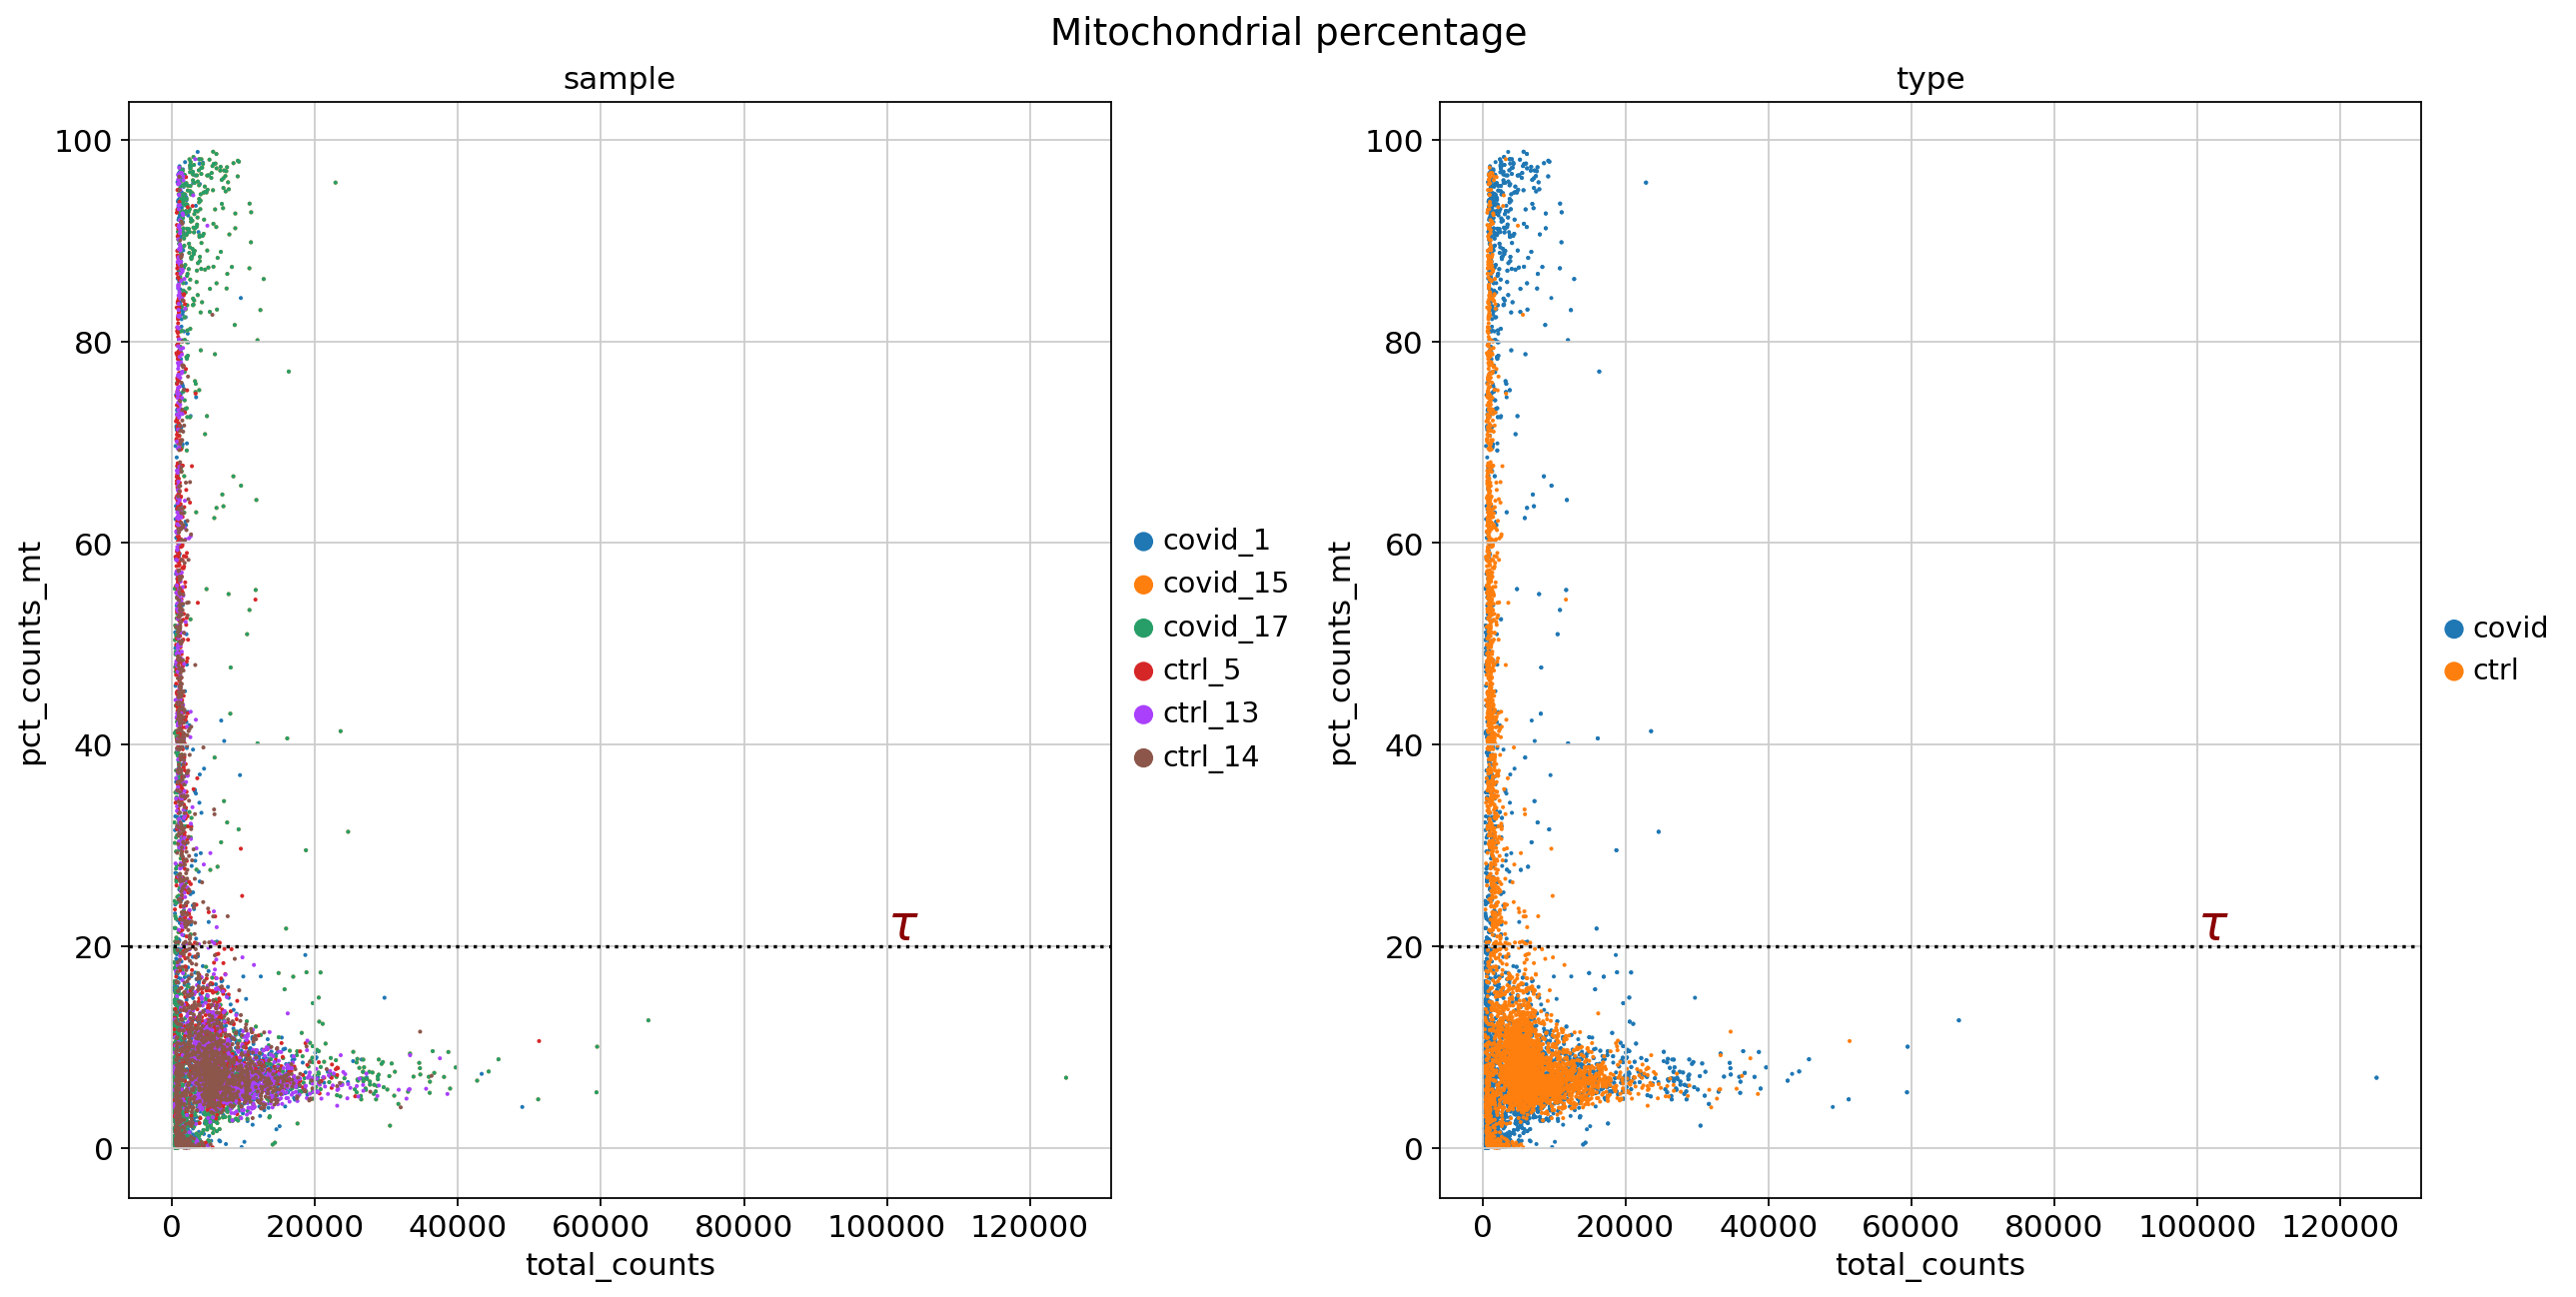

In [25]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 22,
        }
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), constrained_layout=True)
fig.suptitle('Mitochondrial percentage')

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='sample', ax=axes[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='type', ax=axes[1], show=False)

axes[0].axhline(y=20, color='black', linestyle=':', label='threshold')
axes[0].text(100000, 20.65, r'$\tau$', fontdict=font)
axes[1].axhline(y=20, color='black', linestyle=':', label='threshold')
axes[1].text(100000, 20.65, r'$\tau$', fontdict=font)

normalizing counts per cell
    finished (0:00:00)


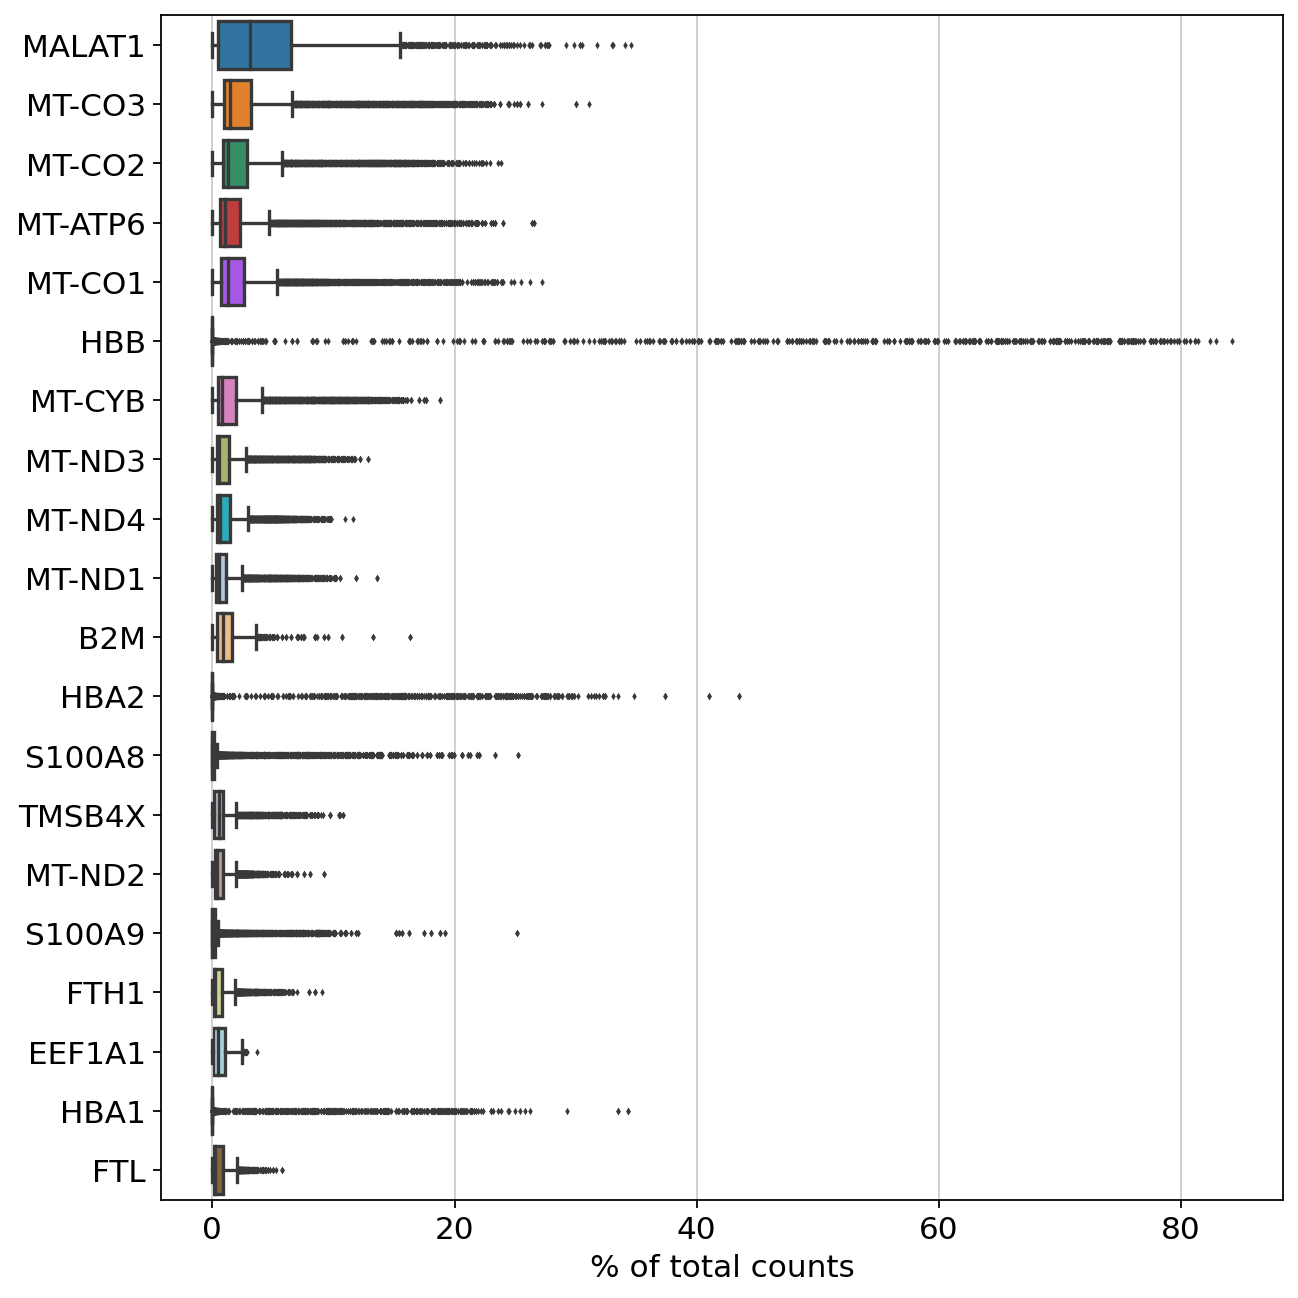

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), constrained_layout=True)
sc.pl.highest_expr_genes(adata, n_top=20, ax=ax)

MALAT1 is frequently detected in poly-A captured RNA-seq data, independent of protocol. The level of detection appears to be cell type-specific and also shows some inverse correlation with cell health. It has been observed that dead/dying cells have higher expression of Malat1.

### FILTERING

In [27]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1100 cells that have less than 200 genes expressed
filtered out 14905 genes that are detected in less than 3 cells
7900 18633


As you can see, MALAT1 constitutes up to 30% of the UMIs from a single cell and the other top genes are mitochondrial and ribosomal genes. It is quite common that nuclear lincRNAs have correlation with quality and mitochondrial reads, so high detection of MALAT1 may be a technical issue. Let us assemble some information about such genes, which are important for quality control and downstream filtering.

#### Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial and low proportion of ribosomal reads. It could be wise to remove those cells, if we have enough cells left after filtering.
Another option would be to either remove all mitochondrial reads from the dataset and hope that the remaining genes still have enough biological signal.
A third option would be to just regress out the percent_mito variable during scaling. In this case we had as much as 99.7% mitochondrial reads in some of the cells, so it is quite unlikely that there is much cell type signature left in those.
Looking at the plots, make reasonable decisions on where to draw the cutoff. In this case, the bulk of the cells are below 20% mitochondrial reads and that will be used as a cutoff. We will also remove cells with less than 5% ribosomal reads.

In [28]:
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 5305


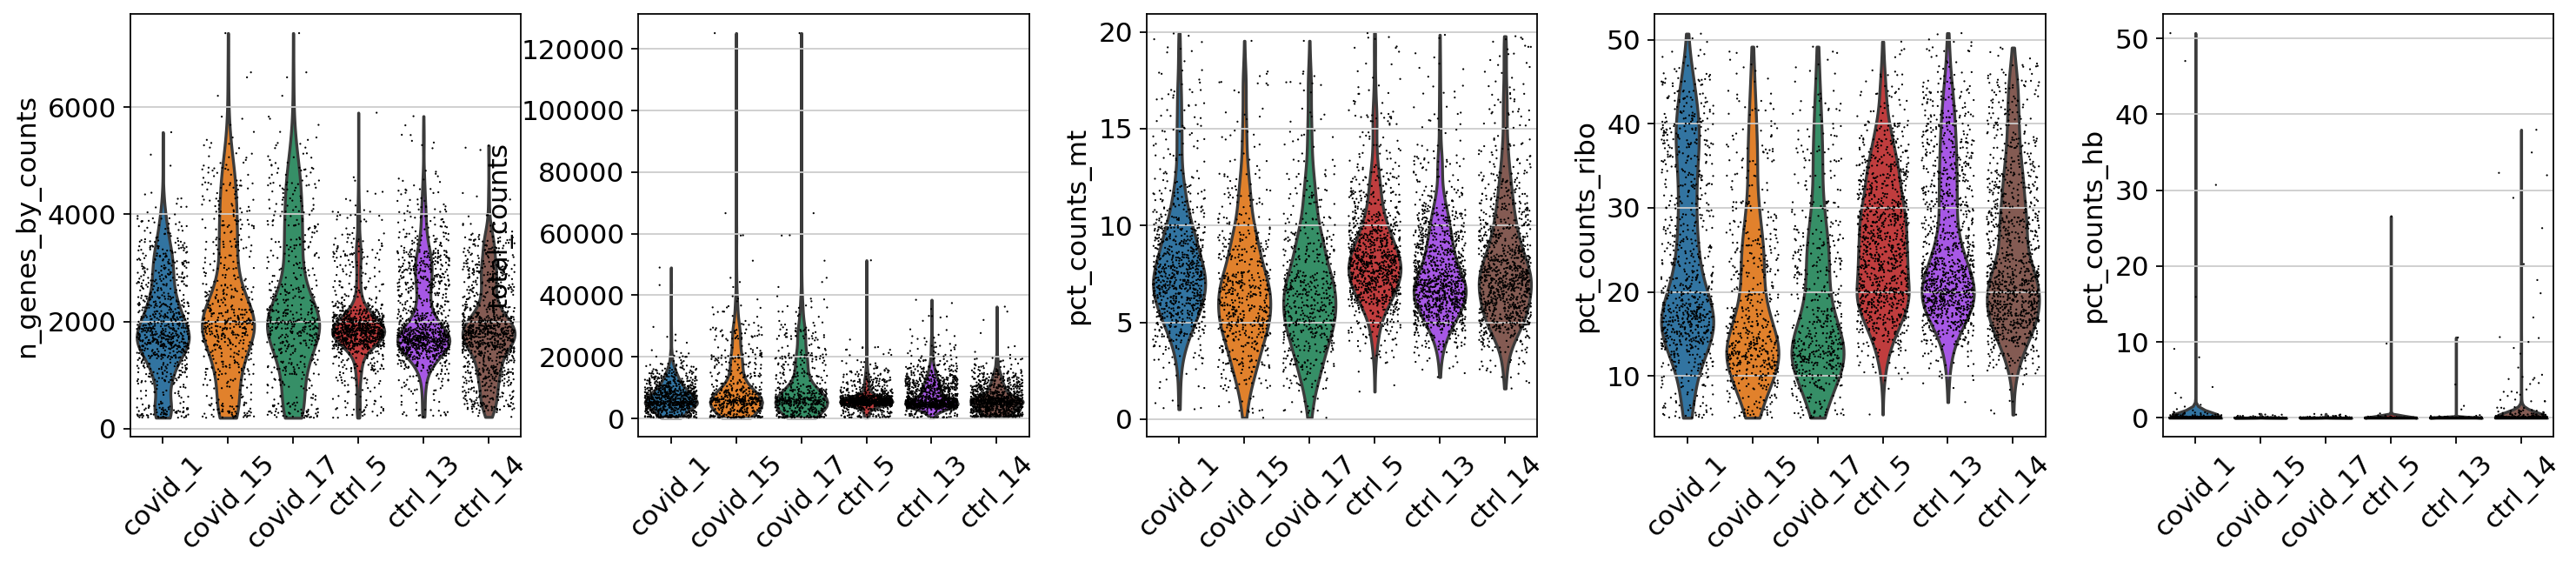

In [29]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation = 45)

In [30]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

5305 18607


### GENDER BIAS

Per cell the proportion of reads that comes from chromosome Y.

In [36]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['RPS4Y1', 'ZFY', 'LINC00278', 'PCDH11Y', 'USP9Y', 'DDX3Y', 'UTY',
       'TMSB4Y', 'TTTY14', 'KDM5D', 'EIF1AY'],
      dtype='object')

In [32]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

Trying to set attribute `.obs` of view, copying.


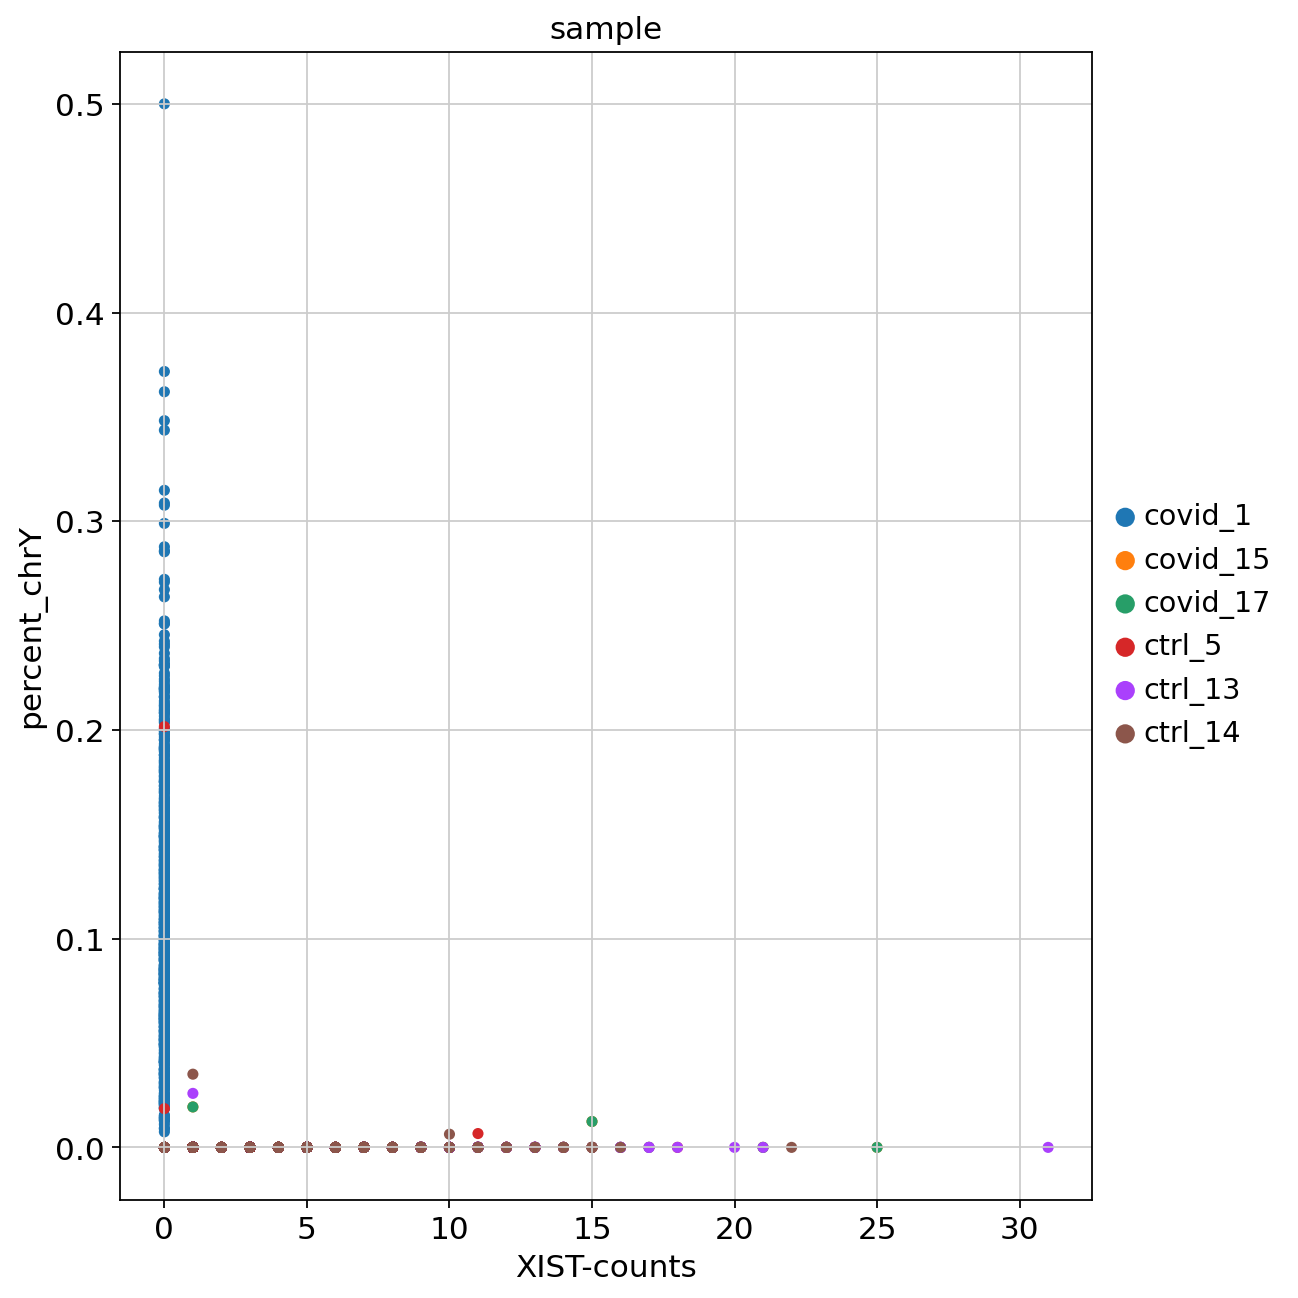

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), constrained_layout=True)
sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample", ax=ax, size=100)

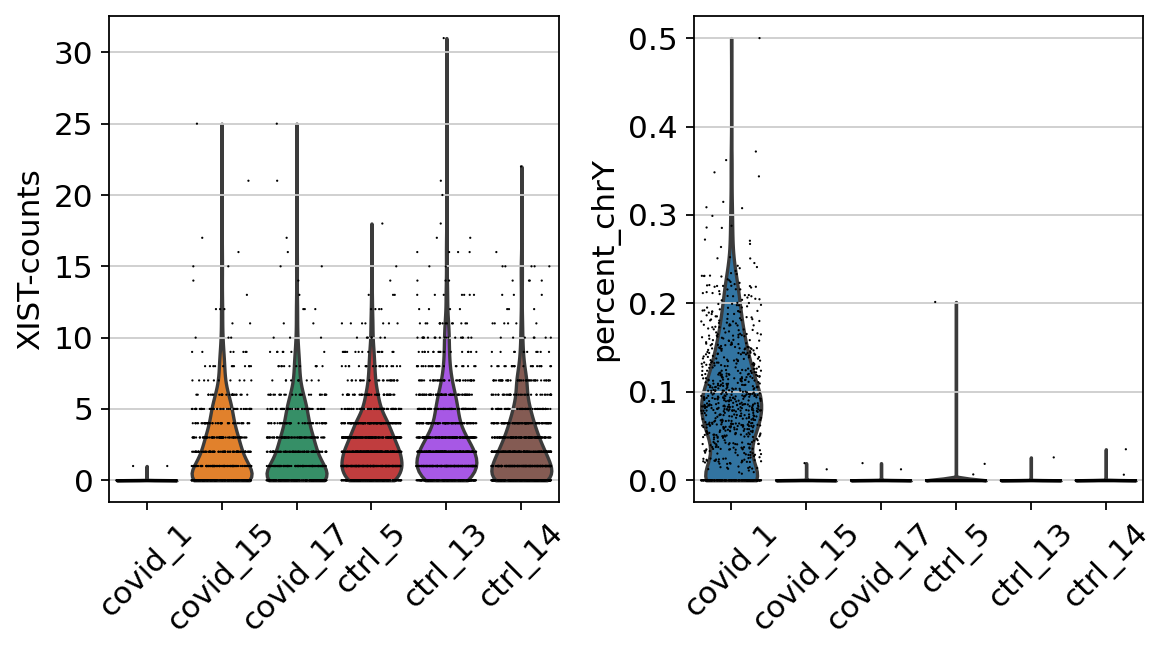

In [34]:
sc.pl.violin(adata, ['XIST-counts', 'percent_chrY'], jitter=0.4, groupby = 'sample', rotation= 45)

In [35]:
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata)
# scale
sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### PREDICT DOUBLETS

Doublets/Mulitples of cells in the same well/droplet is a common issue in scRNAseq protocols. Especially in droplet-based methods whith overloading of cells. 
The percentage of emulsion droplets containing two or more cells is influenced by the quantity of cells loaded into the partitioning device and the prevalence of cell aggregates within the cell suspension. Assuming the absence of cell aggregates, the following table, adopted from the 10X Genomics User Guide, can be used to estimate the occurrence of multiplet partitions within an emulsion.

| Multiplet rate (%) | # of Cell Loaded | # of Cell Recovered |
|:------------------:|:----------------:|:-------------------:|
|        0.40%       |        800       |         500         |
|        0.80%       |       1,600      |        1,000        |
|        1.60%       |       3,200      |        2,000        |
|        2.30%       |       4,800      |        3,000        |
|        3.10%       |       6,400      |        4,000        |
|        3.90%       |       8,000      |        5,000        |
|        4.60%       |       9,600      |        6,000        |
|        5.40%       |      11,200      |        7,000        |
|        6.10%       |      12,800      |        8,000        |
|        6.90%       |      14,400      |        9,000        |
|        7.60%       |      16,000      |        10,000       |

For doublet detection, we will use the package Scrublet, so first we need to get the raw counts from adata.raw.X and run scrublet with that matrix. Then we add in the doublet prediction info into our anndata object.

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 42.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.8%
Elapsed time: 6.6 seconds


174

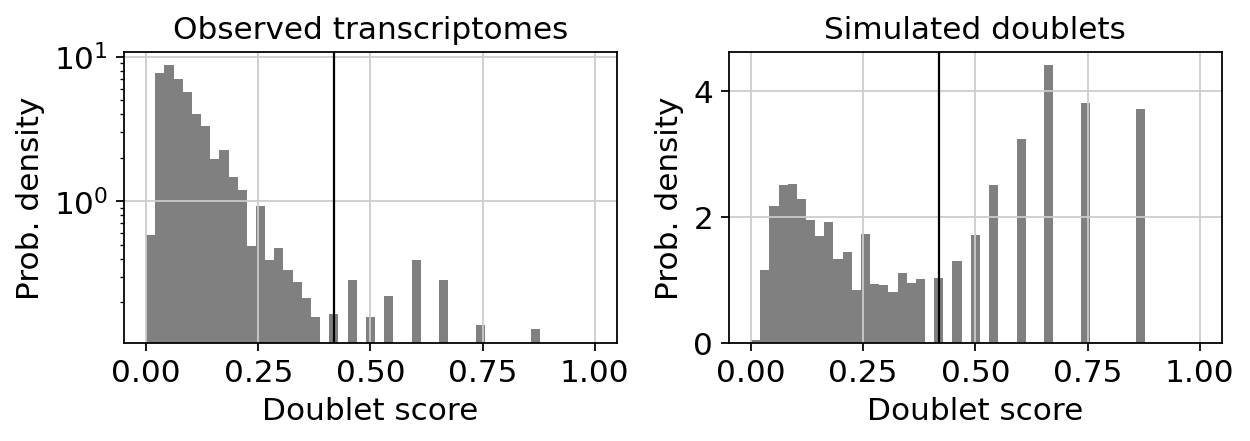

In [37]:
import scrublet as scr

scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()
sum(adata.obs['predicted_doublets'])

In [38]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


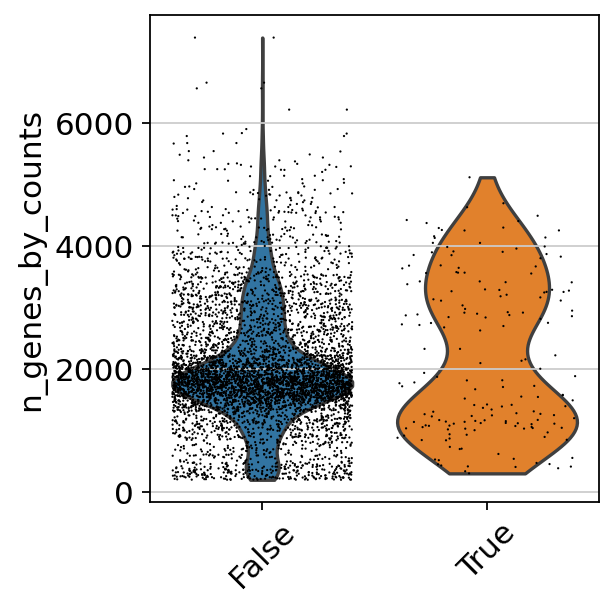

In [39]:
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, groupby = 'doublet_info', rotation=45)

In [40]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

extracting highly variable genes


/home/andres/.pyenv/versions/tf-lab/lib/python3.7/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


/home/andres/.pyenv/versions/tf-lab/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:240: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values
/home/andres/.pyenv/versions/tf-lab/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


    finished (0:00:19)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


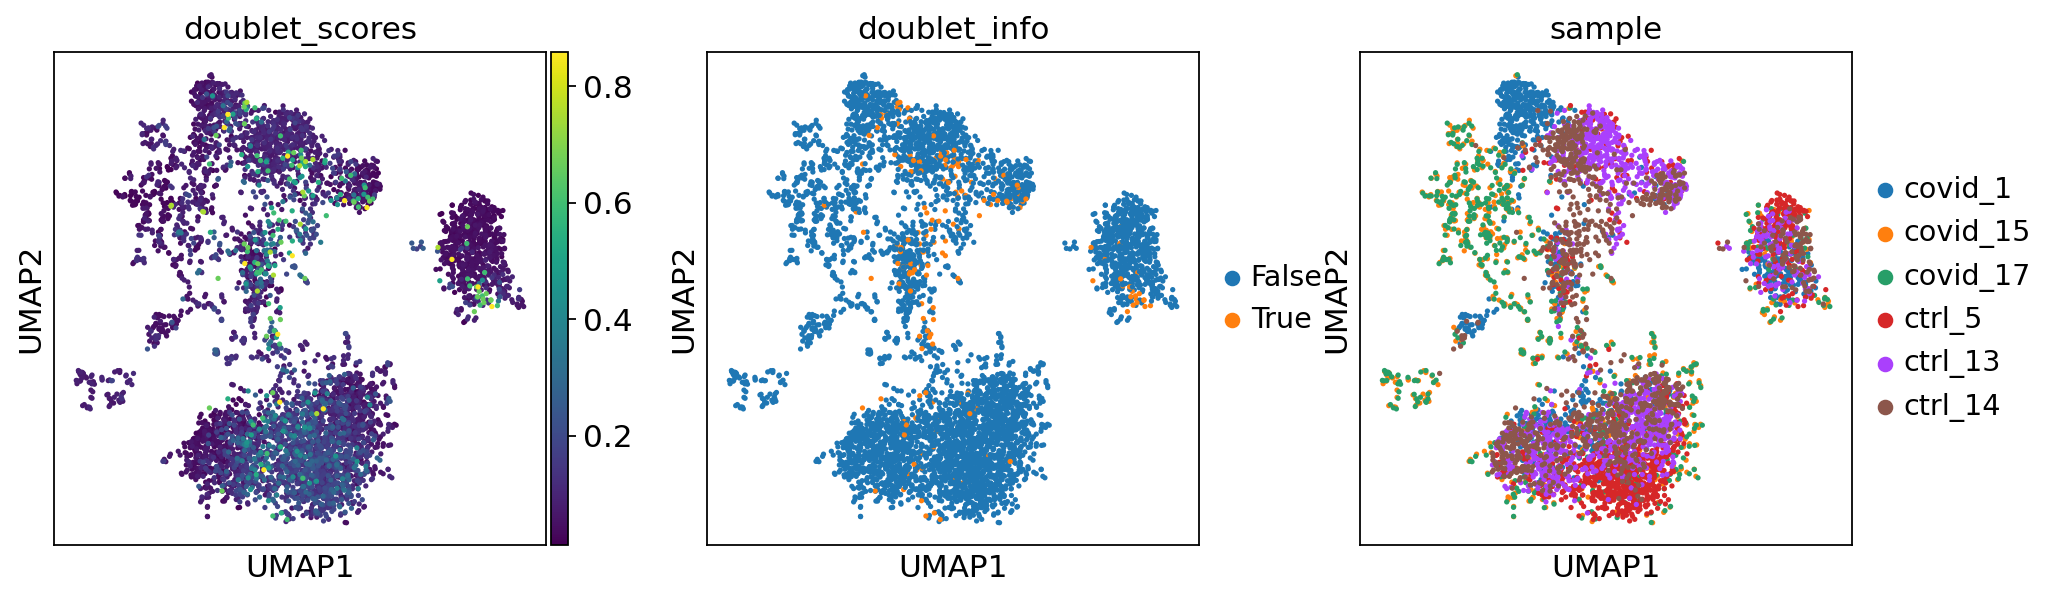

In [41]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info','sample'])

In [42]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(5131, 18607)


## DIMENSIONALITY REDUCTION

In [43]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata)
# store normalized counts in the raw slot, 
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata
adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 5131 × 18607
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'percent_chrY', 'XIST-counts', 'n_counts', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'sample_colors', 'type_colors', 'log1p', 'doublet_info_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 3248


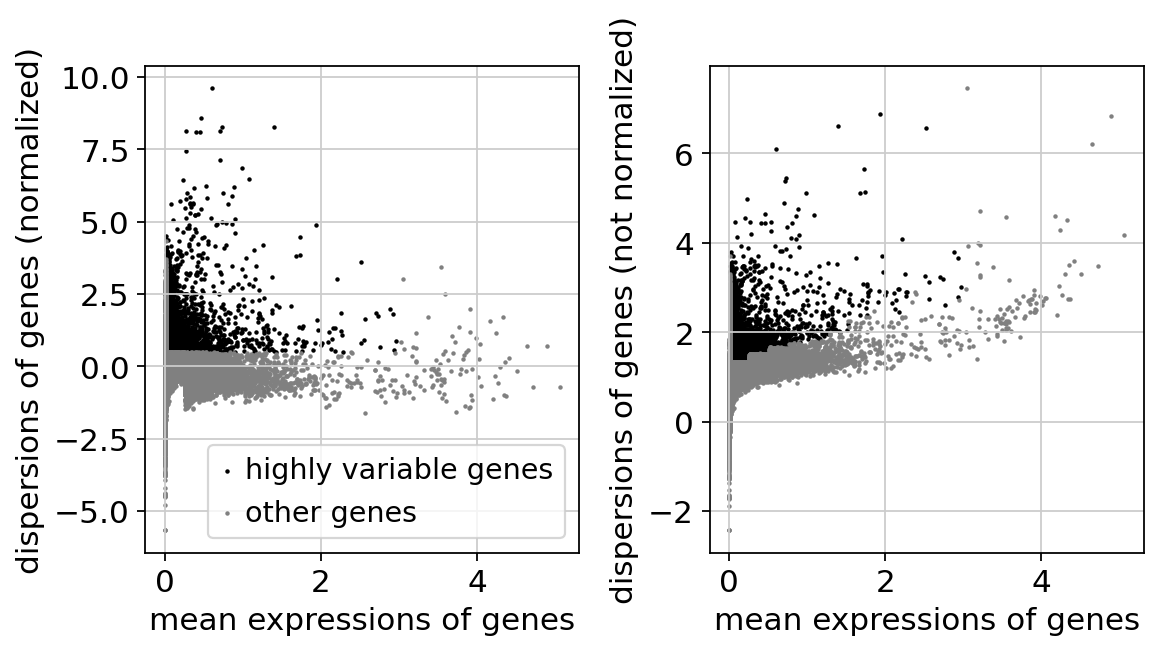

In [44]:
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

In [45]:
# regress out unwanted variables
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:31)


### PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


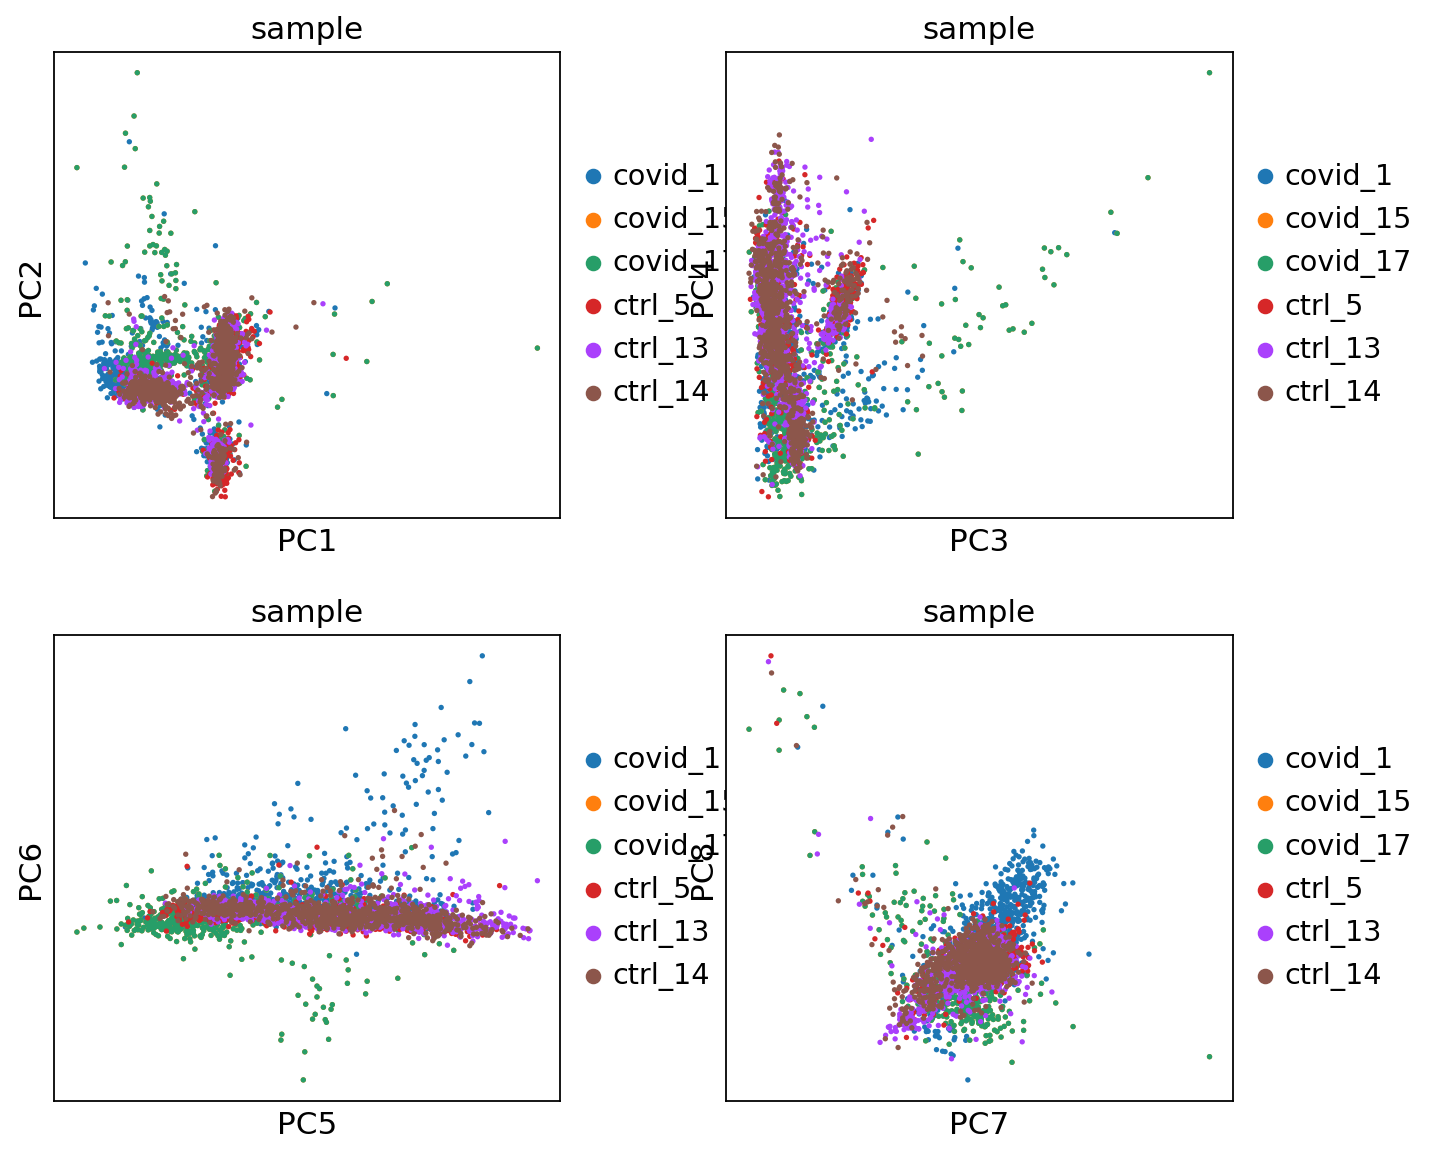

In [46]:
sc.tl.pca(adata, svd_solver='arpack')
# plot more PCS
sc.pl.pca(adata, color='sample', components = ['1,2','3,4','5,6','7,8'], ncols=2)

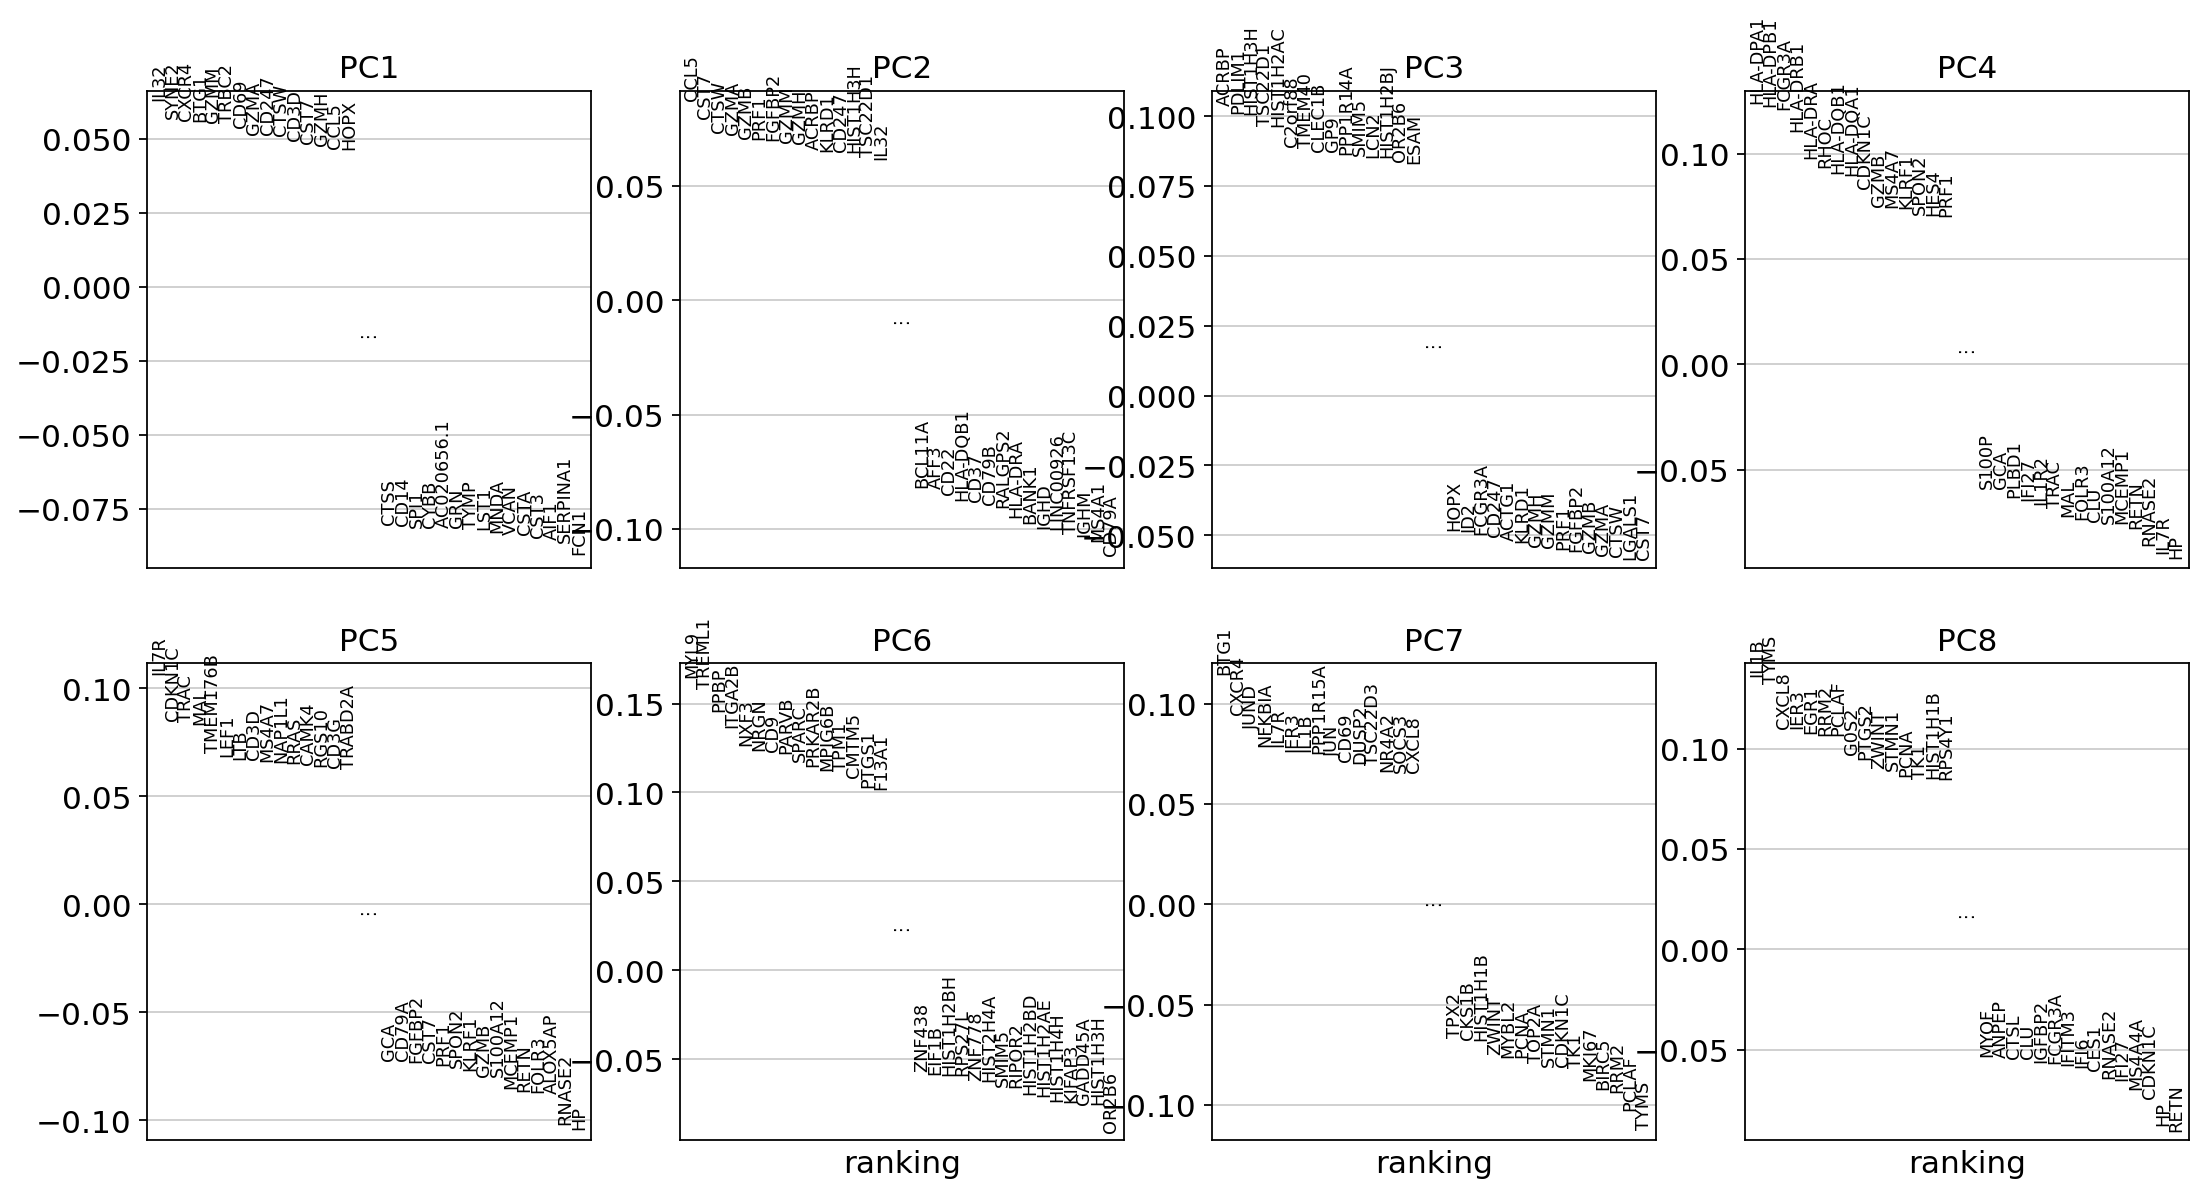

In [47]:
#Plot loadings
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

We can also plot the amount of variance explained by each PC.

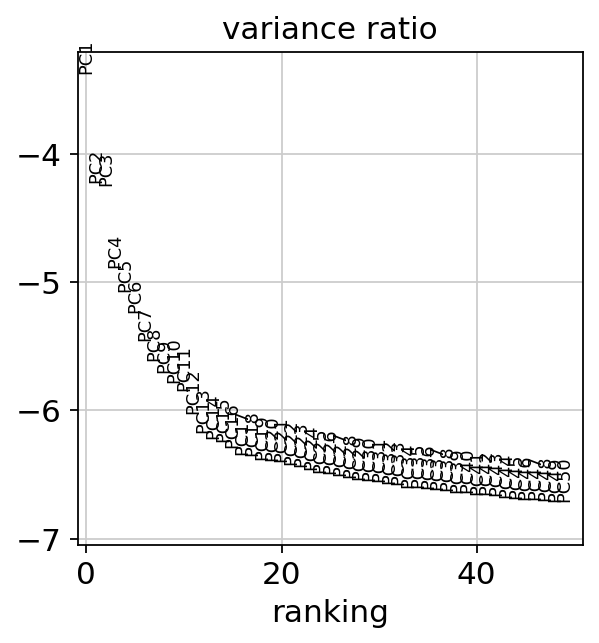

In [49]:
ax = sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50, show=False)

The PCs are ranked based on significance of explaining the data’s variance, with PC1 being the highest-ranking PC. The lower ranking the PC, the less it contributes to explaining the variance of the data. Therefore, using the lower ranked PCs is generally not advantageous because it increases the computational load, yet barely adds any information to the representation of the biological variability of the cells.

### UNIFORM MANIFOLD APPROXIMATION AND PROJECTION (UMAP)

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data

1. The data is uniformly distributed on Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

<p>
[2] <cite>UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction</cite> Leland McInnes, John Healy, James Melville (2020). eprint 1802.03426 https://arxiv.org/abs/1802.03426v3</p>

#### NEIGHBORHOOD GRAPH

The UMAP implementation in SCANPY uses a neighborhood graph as the distance matrix, so we need to first calculate the graph.

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


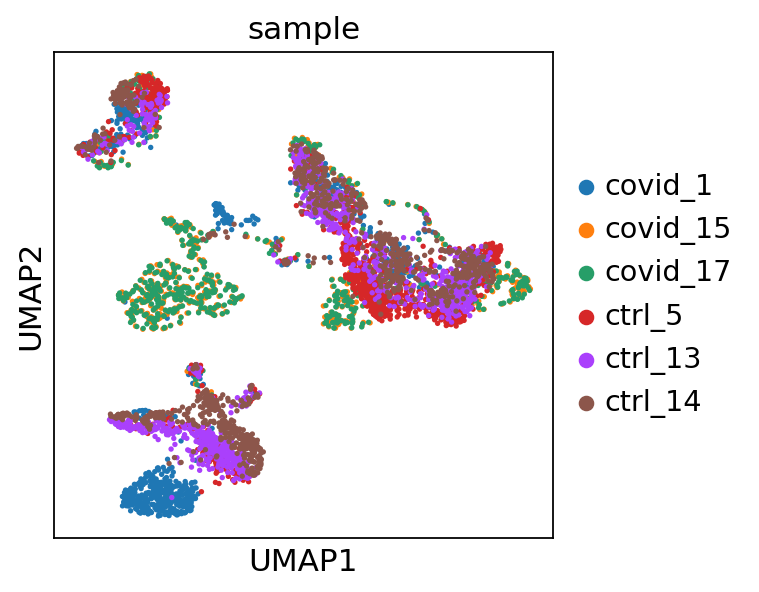

In [62]:
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)

# Calculate umap projection
sc.tl.umap(adata)
# Plot
sc.pl.umap(adata, color='sample')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


<AxesSubplot:title={'center':'UMAP8'}, xlabel='UMAP3', ylabel='UMAP4'>

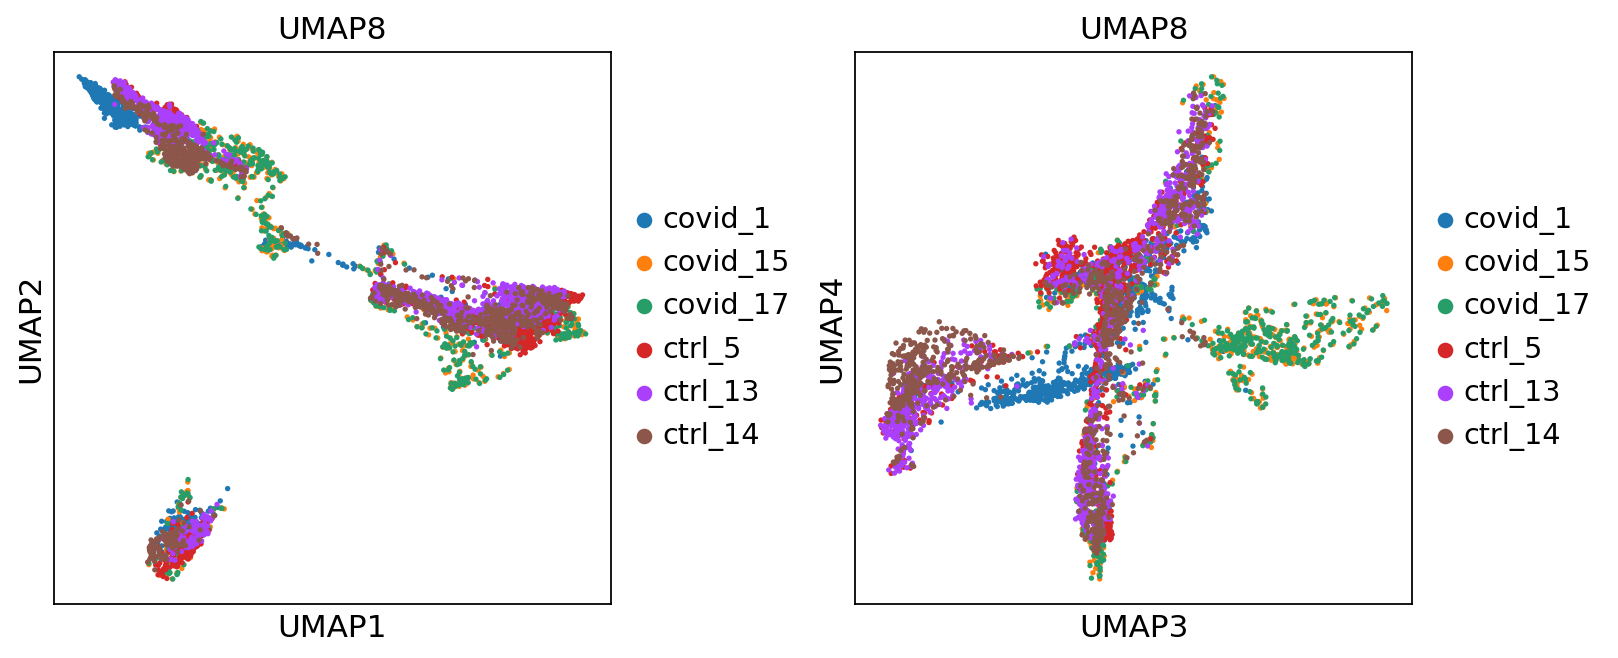

In [63]:
#run with 8 components, save to a new object so that the umap with 2D is not overwritten.
umap8 = sc.tl.umap(adata, n_components=8, copy=True)
fig, axs = plt.subplots(1, 2, figsize=(10,4),constrained_layout=True)
sc.pl.umap(umap8, color='sample', title="UMAP8", show=False, ax=axs[0], components=[1,2])
sc.pl.umap(umap8, color='sample', title="UMAP8", show=False, ax=axs[1], components=[3,4])

#### PLOTING GENES OF INTEREST

|          Markers         |      Cell Type     |
|:------------------------:|:------------------:|
| CD3E                     | T cells            |
| CD3E CD4                 | CD4+ T cells       |
| CD3E CD8A                | CD8+ T cells       |
| GNLY, NKG7               | NK cells           |
| MS4A1                    | B cells            |
| CD14, LYZ, CST3, MS4A7   | CD14+ Monocytes    |
| FCGR3A, LYZ, CST3, MS4A7 | FCGR3A+  Monocytes |
| FCER1A, CST3             | DCs                |

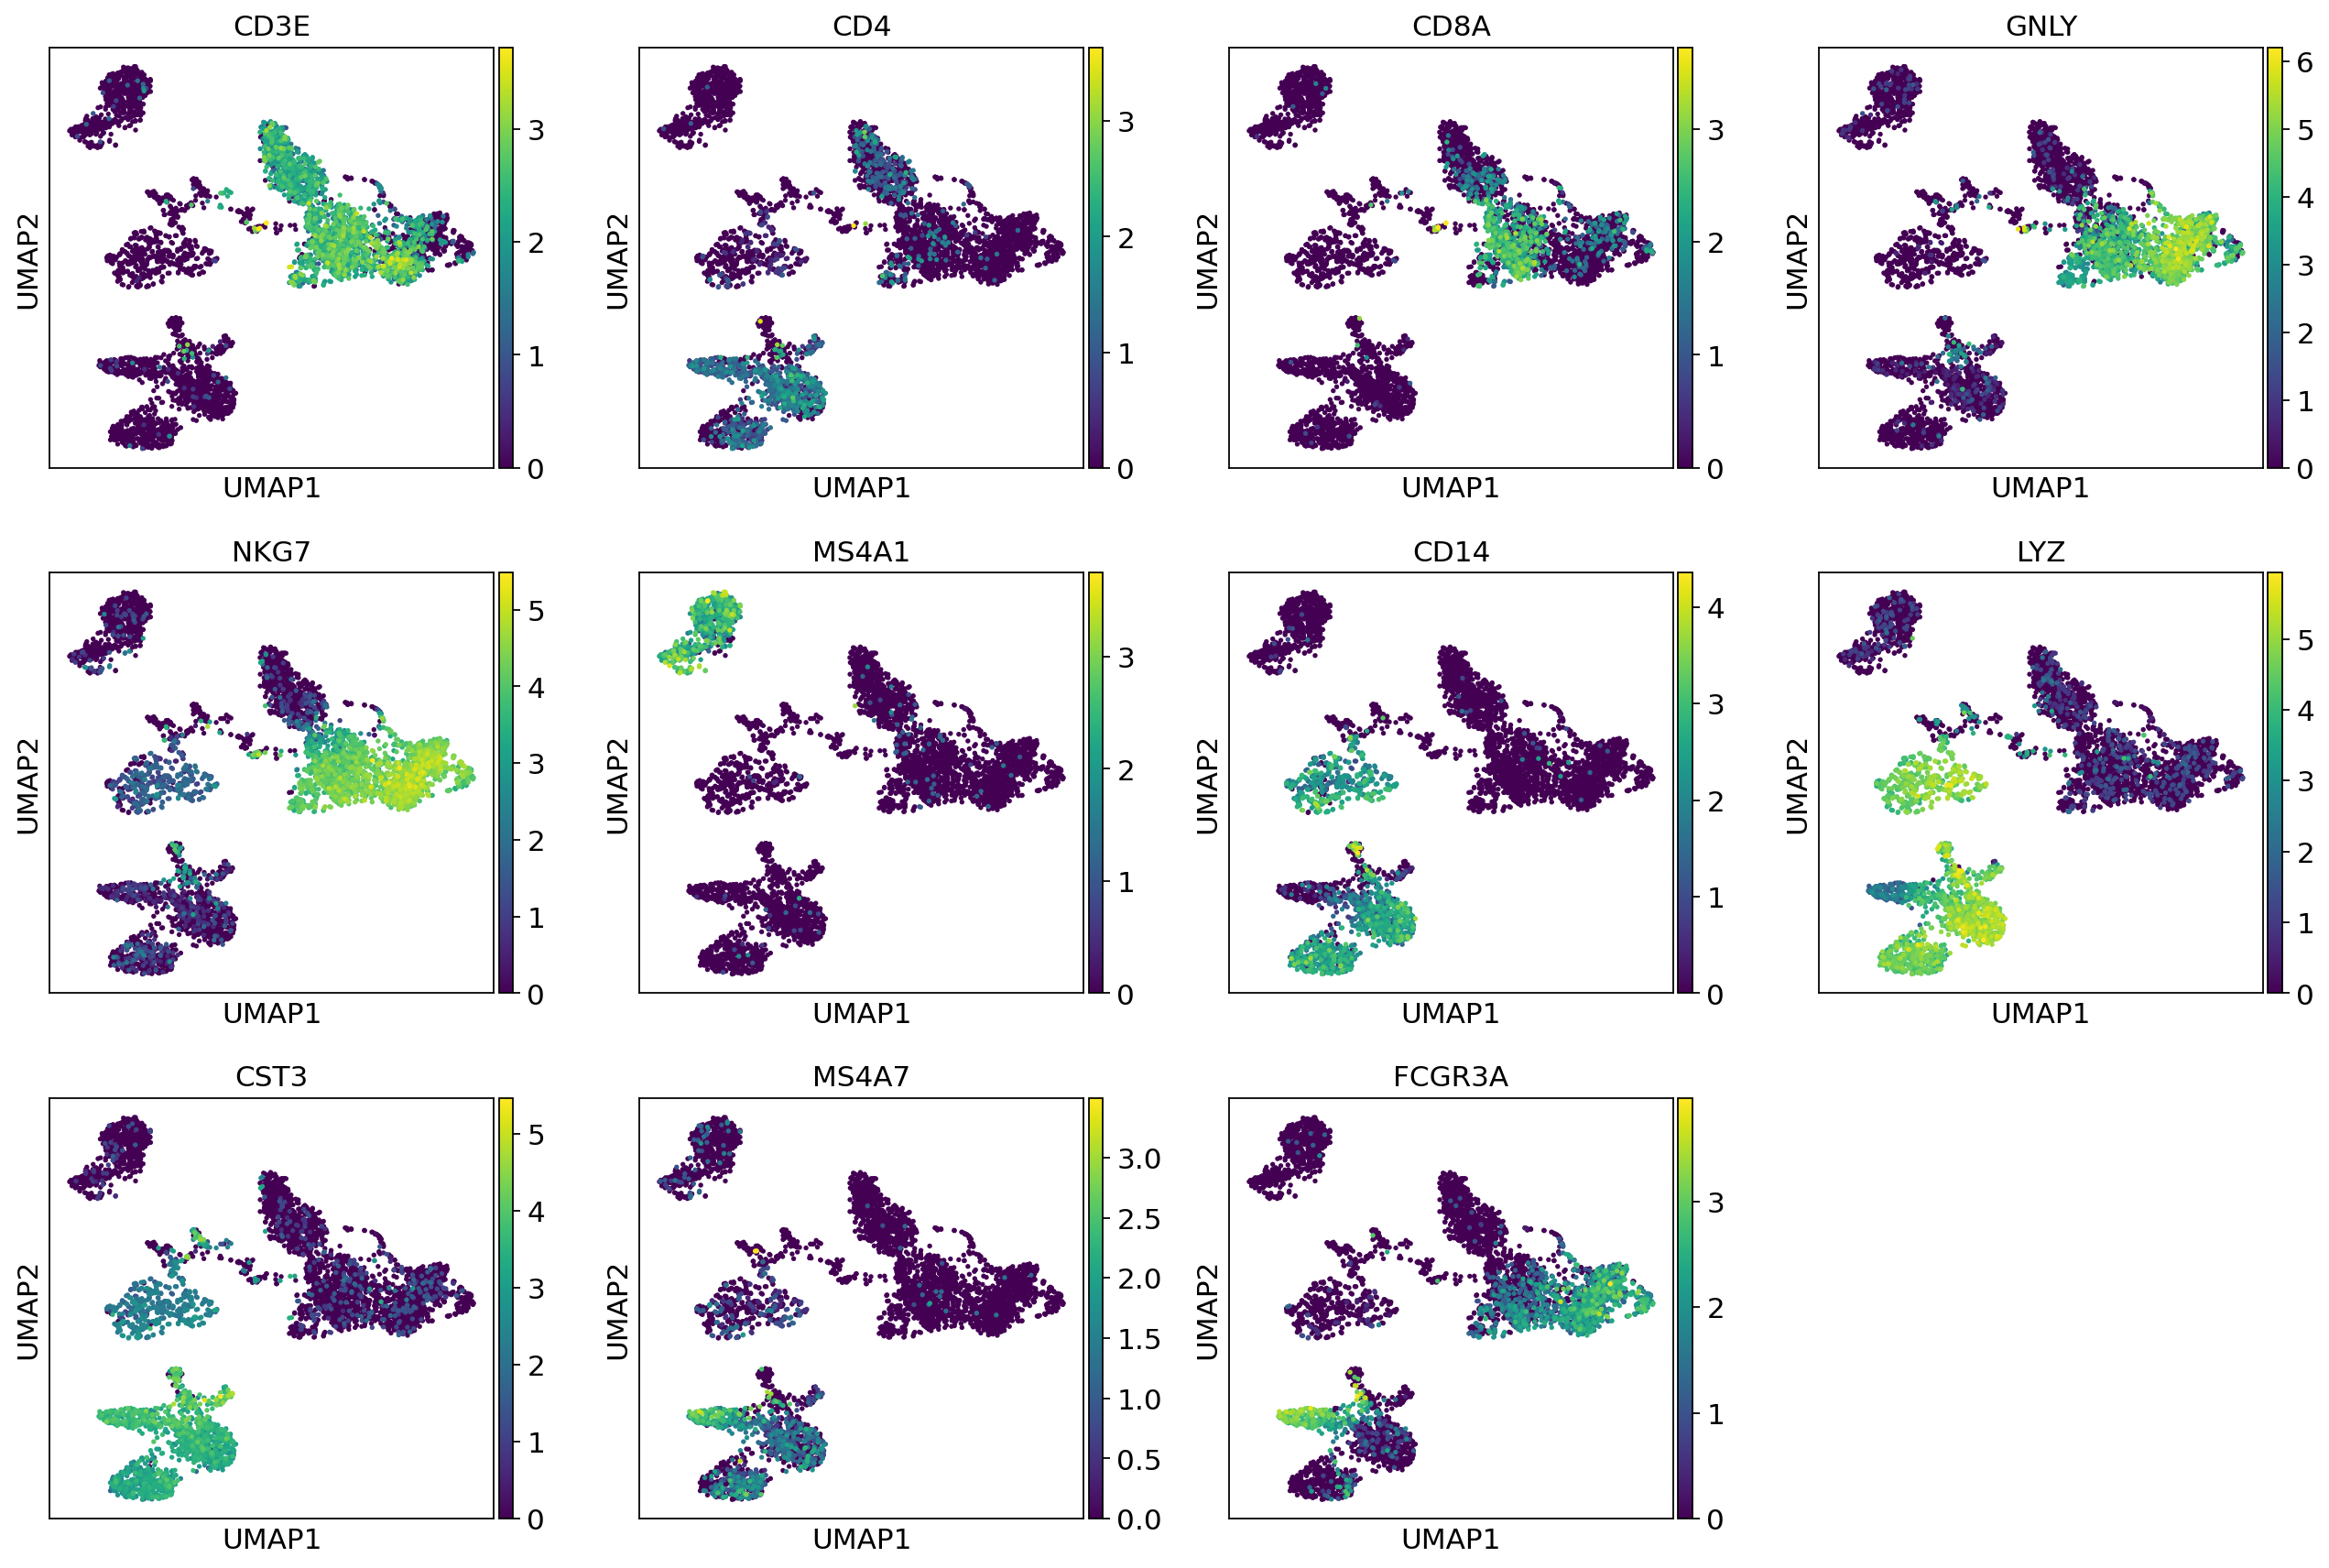

In [64]:
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"])

In [99]:
adata.write_h5ad('../data/GSE149689/results/scanpy_dr_covid.h5ad')

In [65]:
adata

AnnData object with n_obs × n_vars = 5131 × 3248
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'percent_chrY', 'XIST-counts', 'n_counts', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'sample_colors', 'type_colors', 'log1p', 'doublet_info_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## LEIDEN

Leiden algorithm, which guarantees that communities are well connected. The algorithm is partly based on the smart local move algorithm, which itself can be seen as an improvement of the Louvain algorithm. The Leiden algorithm also takes advantage of the idea of speeding up the local moving of nodes and the idea of moving nodes to random neighbours. 

In [66]:
sc.tl.leiden(adata, key_added = "leiden_1.0") # default resolution in 1.0
sc.tl.leiden(adata, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(adata, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution = 1.4, key_added = "leiden_1.4")

running Leiden clustering
    finished: found 17 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


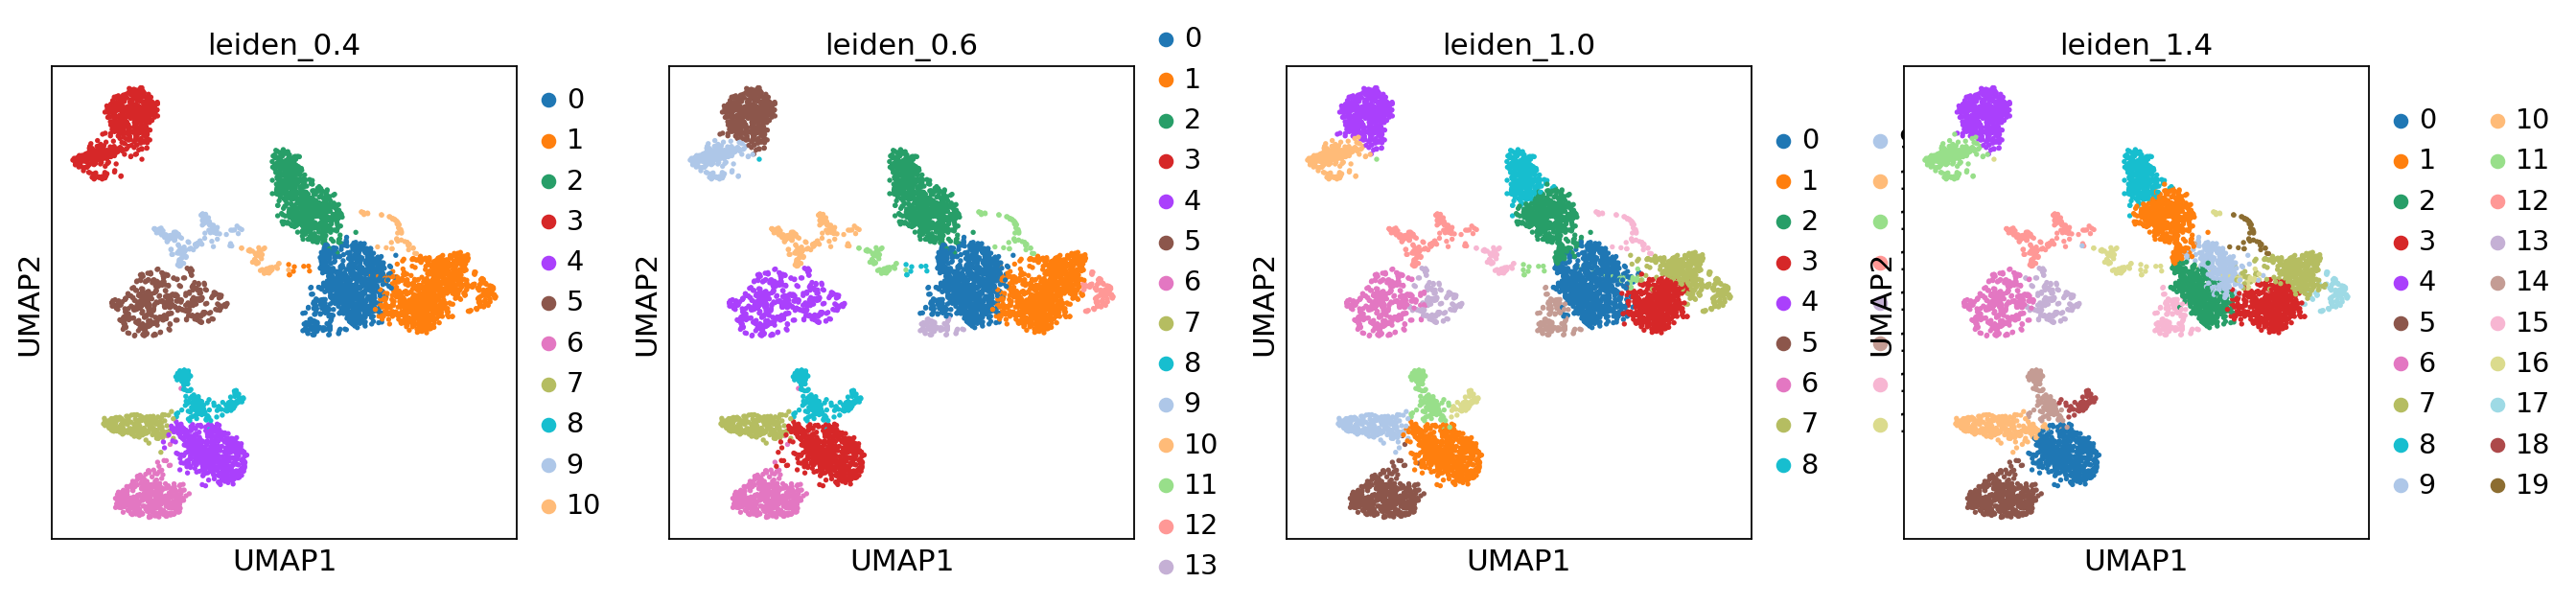

In [67]:
sc.pl.umap(adata, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_0.6']`


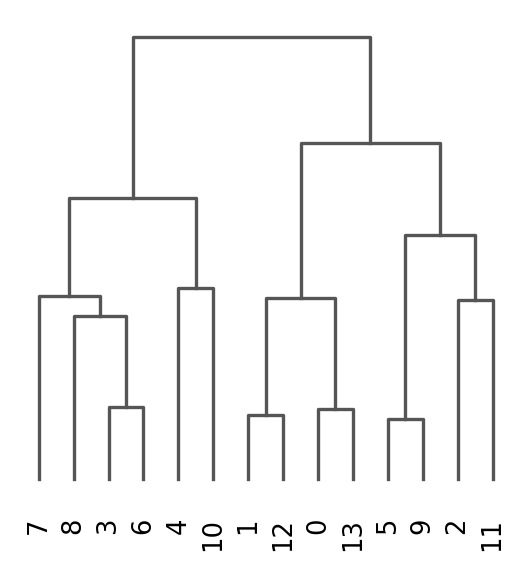

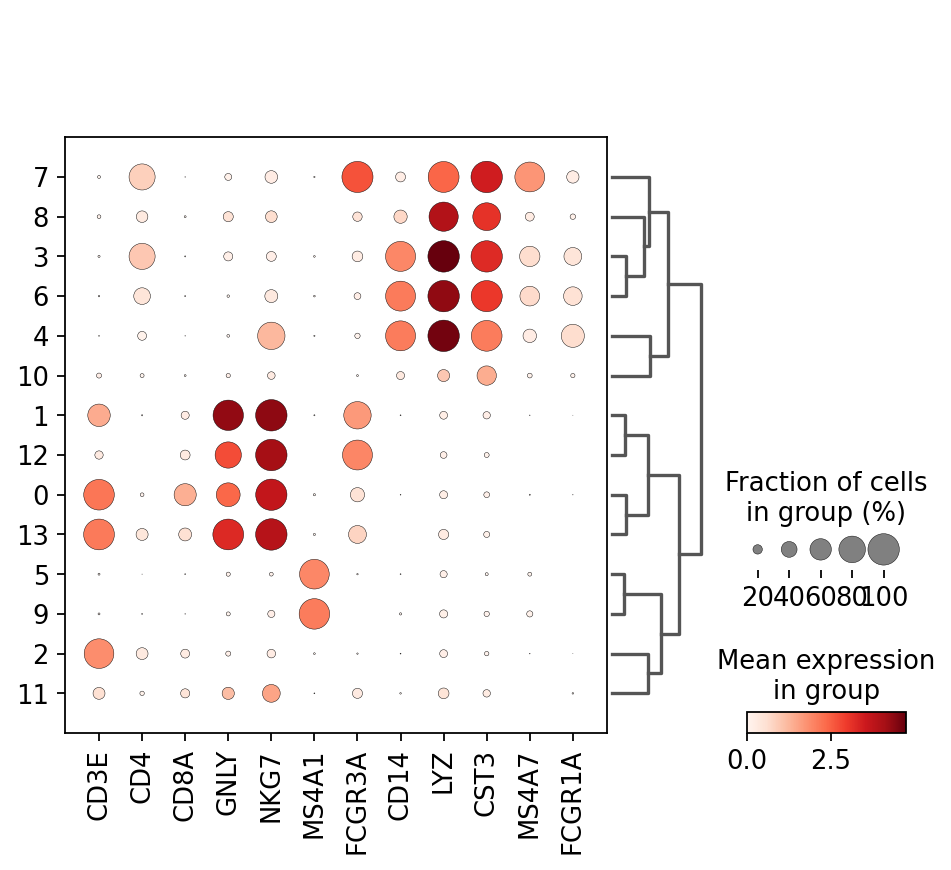

In [68]:
sc.tl.dendrogram(adata, groupby = "leiden_0.6")
sc.pl.dendrogram(adata, groupby = "leiden_0.6")

genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","FCGR3A","CD14","LYZ","CST3","MS4A7","FCGR1A"]
sc.pl.dotplot(adata, genes, groupby='leiden_0.6', dendrogram=True)

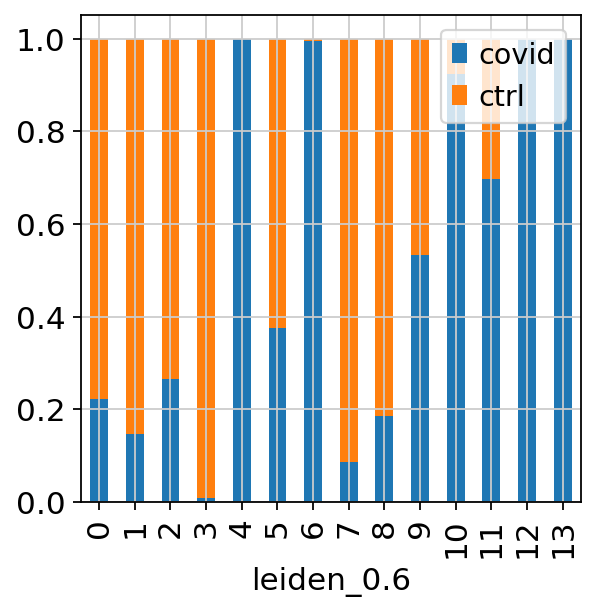

In [69]:
tmp = pd.crosstab(adata.obs['leiden_0.6'],adata.obs['type'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')

### LOUVAIN

The Louvain method is an algorithm to detect communities in large networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_1.4', the cluster labels (adata.obs, categorical) (0:00:00)


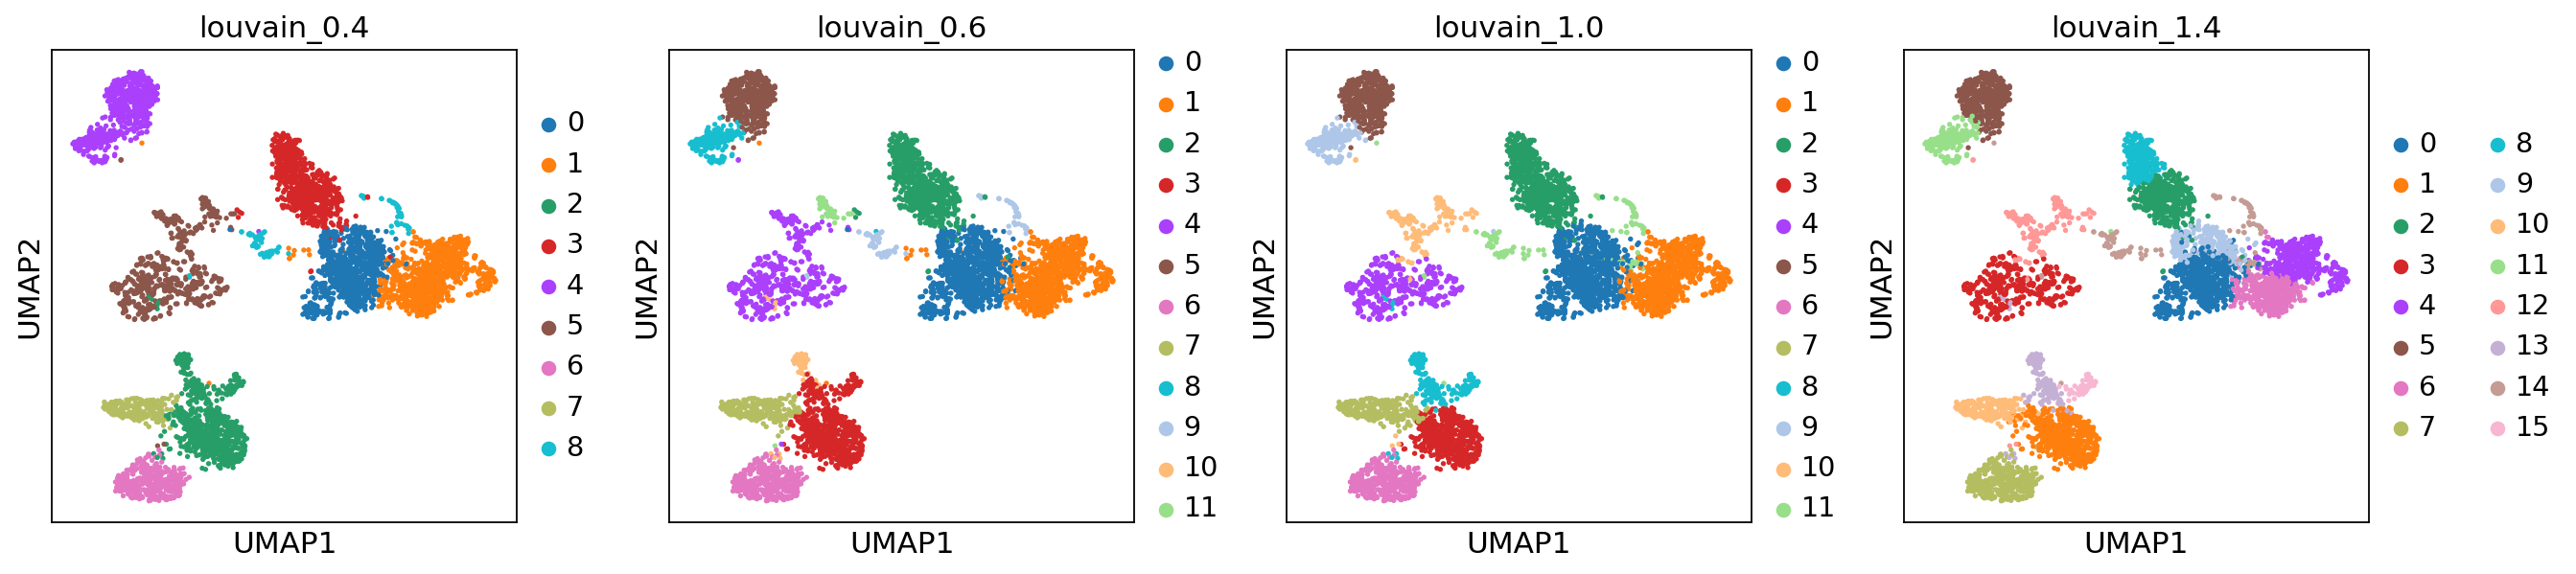

In [70]:
sc.tl.louvain(adata, key_added = "louvain_1.0") # default resolution in 1.0
sc.tl.louvain(adata, resolution = 0.6, key_added = "louvain_0.6")
sc.tl.louvain(adata, resolution = 0.4, key_added = "louvain_0.4")
sc.tl.louvain(adata, resolution = 1.4, key_added = "louvain_1.4")

sc.pl.umap(adata, color=['louvain_0.4', 'louvain_0.6', 'louvain_1.0','louvain_1.4'])

In [71]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(5131, 3248)
(5131, 18607)
  (0, 1)	0.90436876
  (0, 6)	0.90436876
  (1, 6)	0.9678403
  (2, 6)	0.51237714


### T-TEST

ranking genes
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


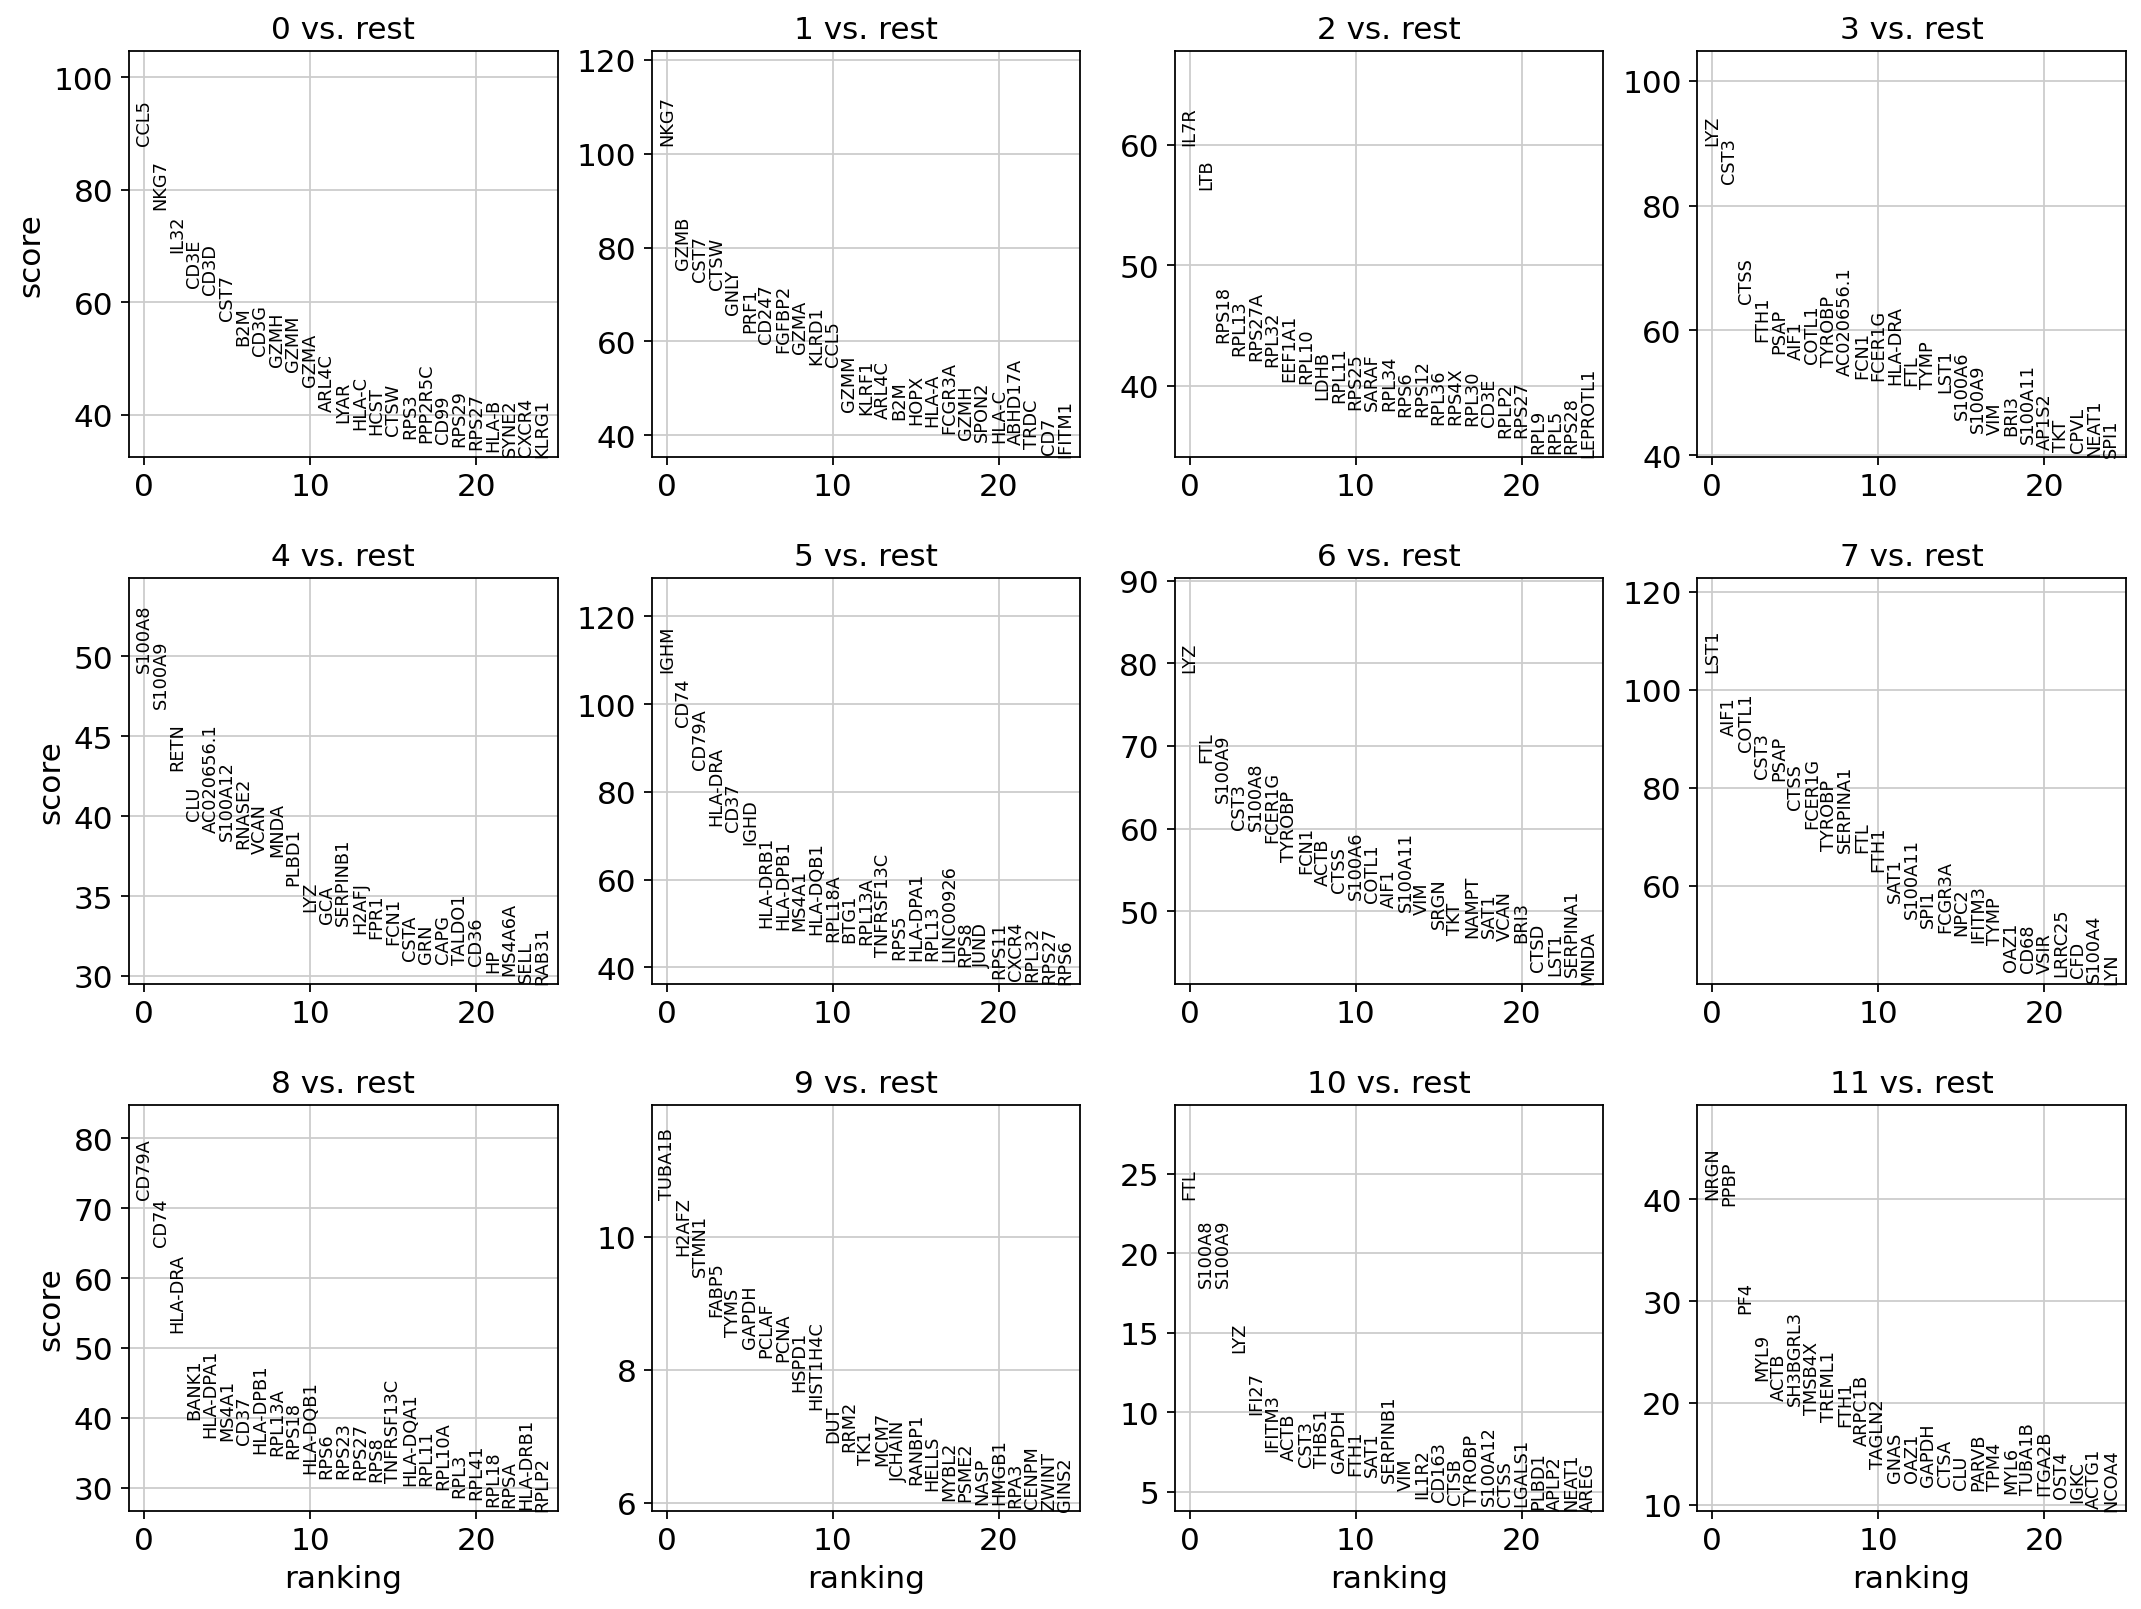

In [72]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

### WILCOXON RANK-SUM

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


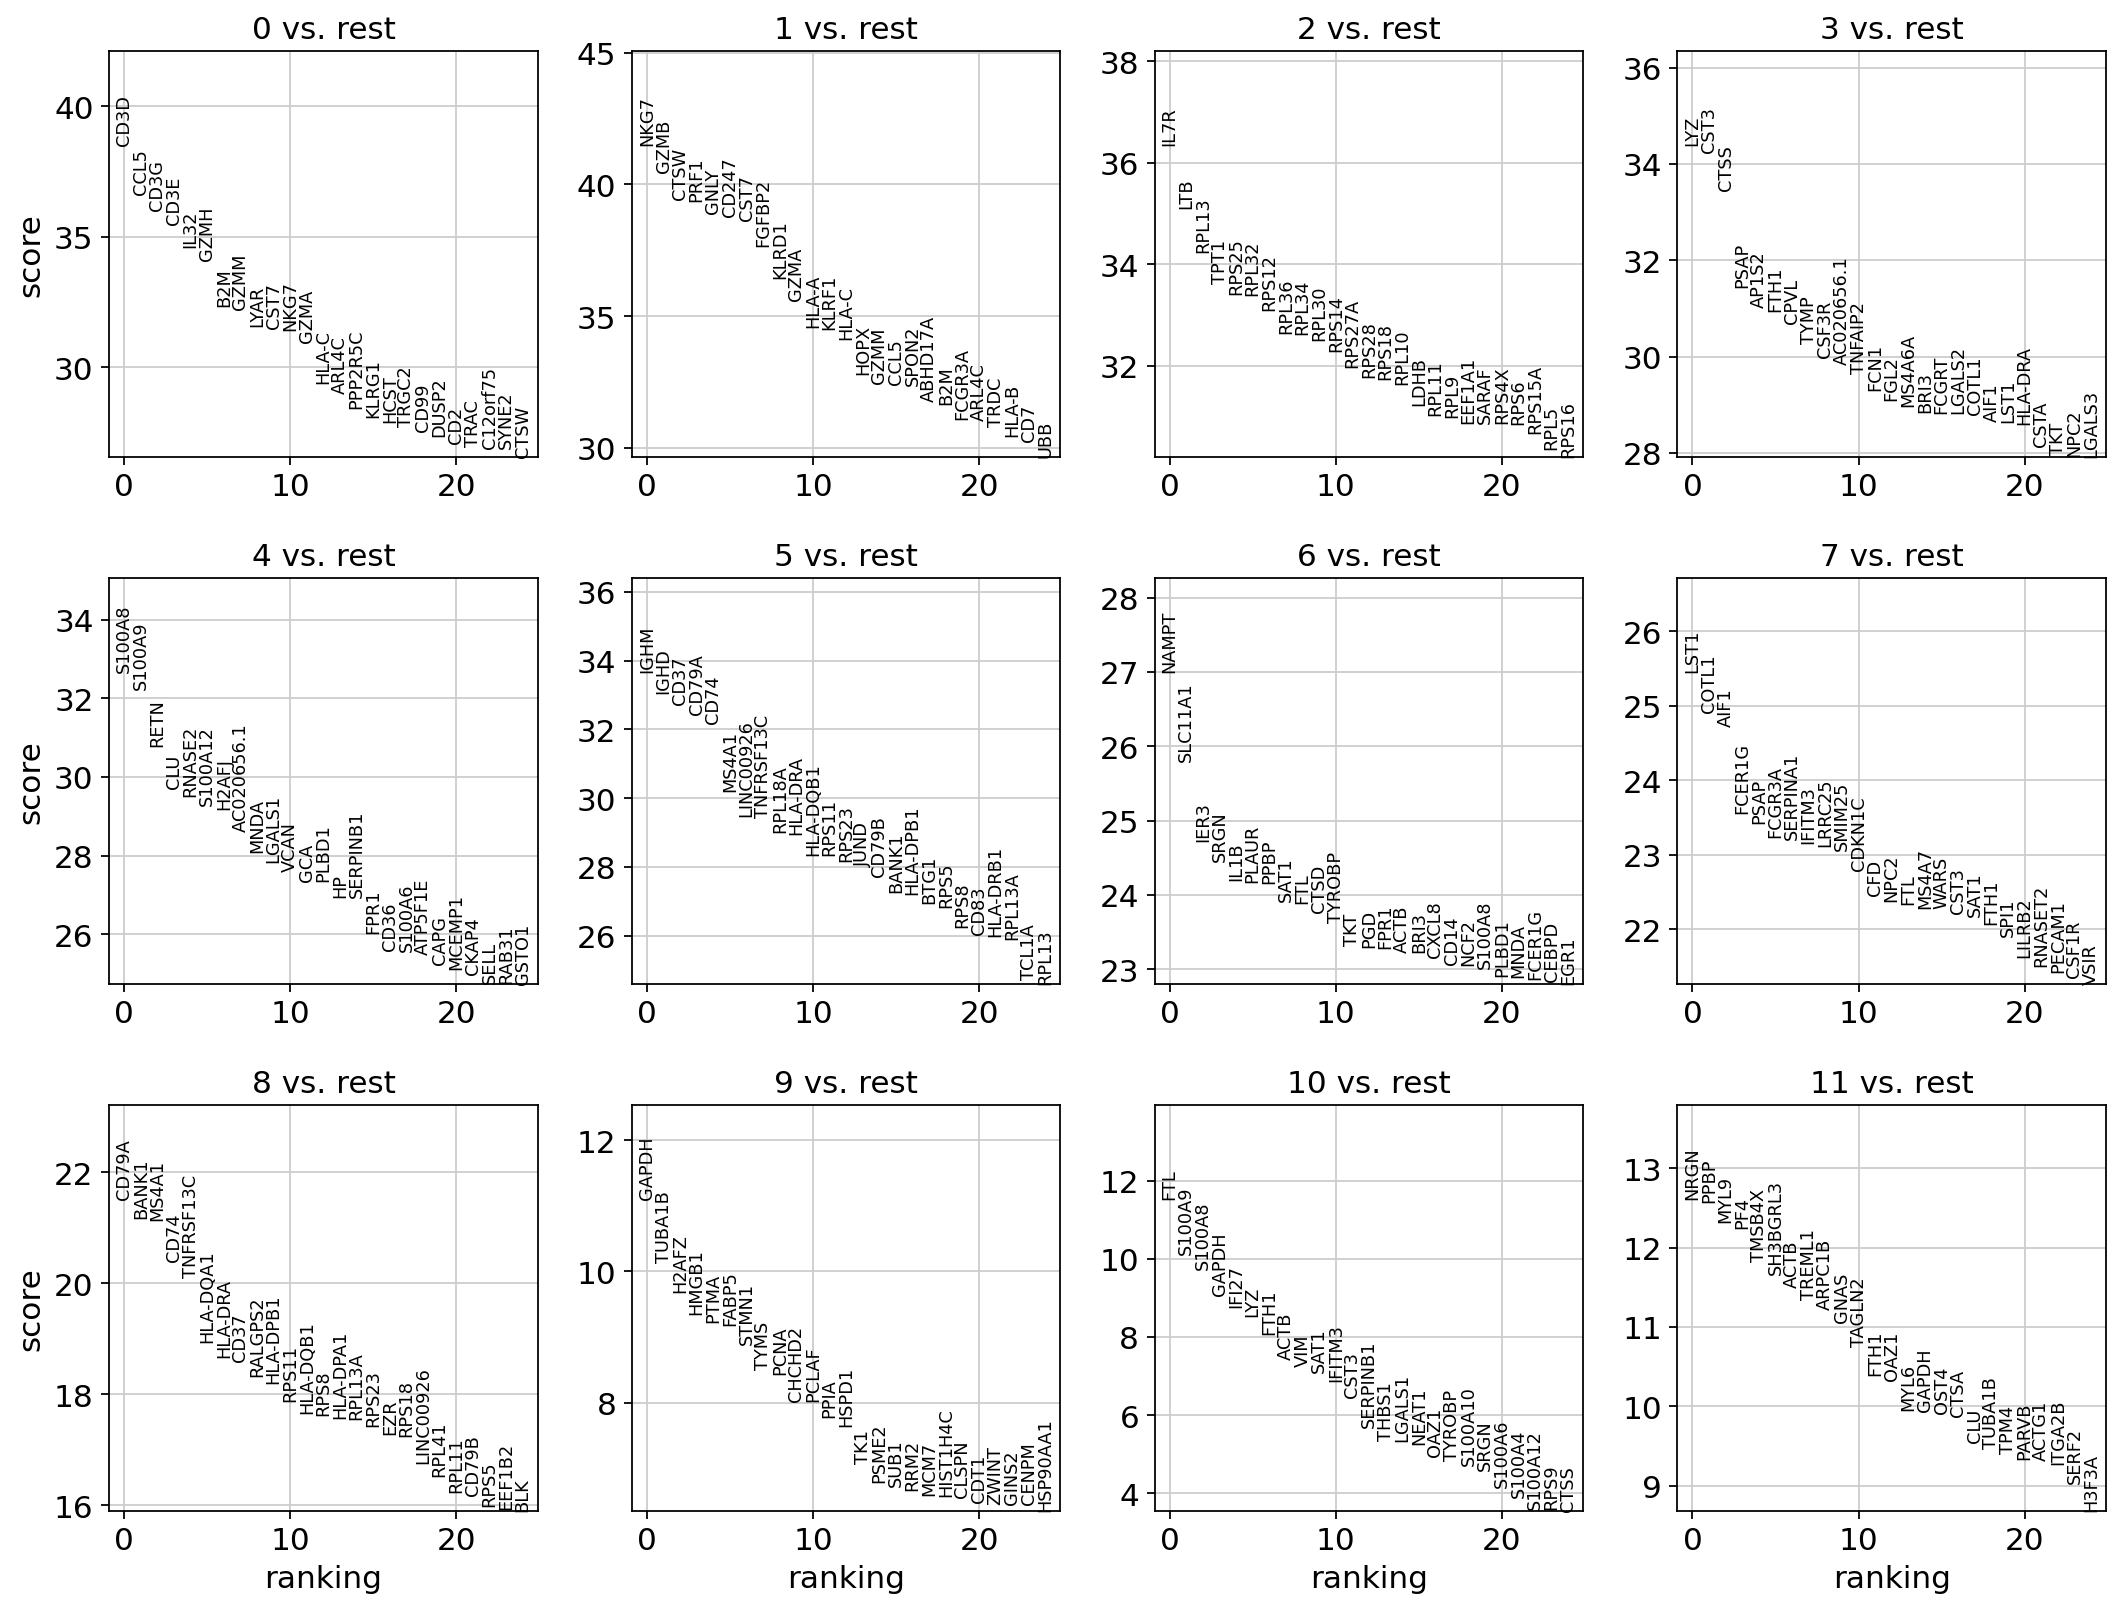

In [73]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

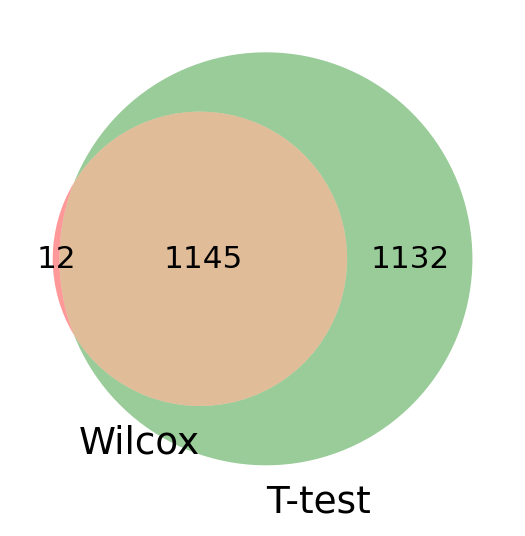

In [75]:
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn2

v = venn2([set(wc), set(tt)], ('Wilcox', 'T-test') )
plt.show()

### COMPARE SPECIFIC CLUSTERS

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


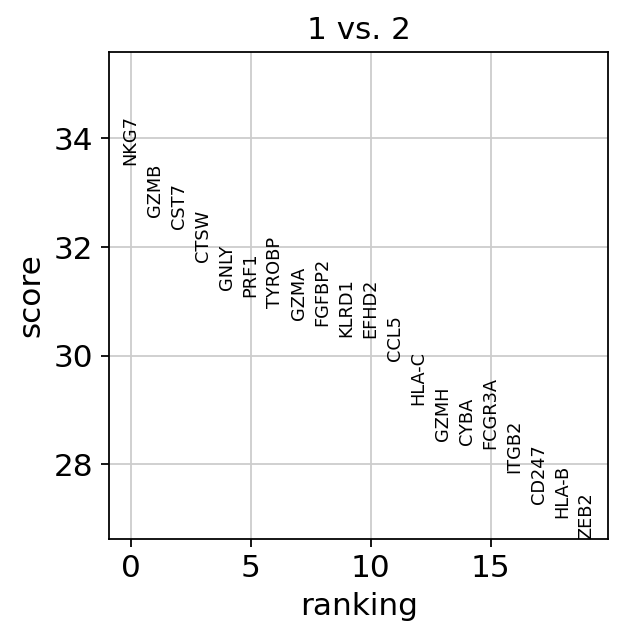

In [76]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

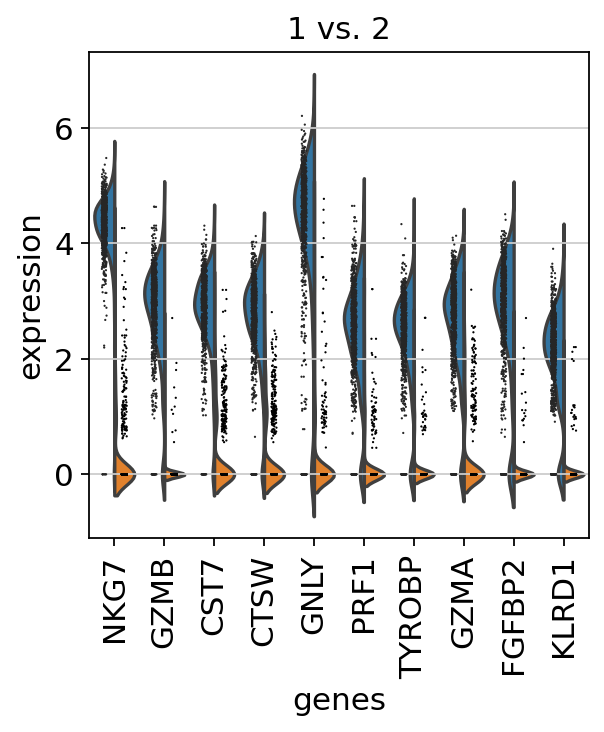

In [77]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)

### DIFFERENTIAL EXPRESSION ACROSS CONDITIONS

In [78]:
cl1 = adata[adata.obs['louvain_0.6'] == '1',:]
cl1.obs['type'].value_counts()

ctrl     625
covid    210
Name: type, dtype: int64

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


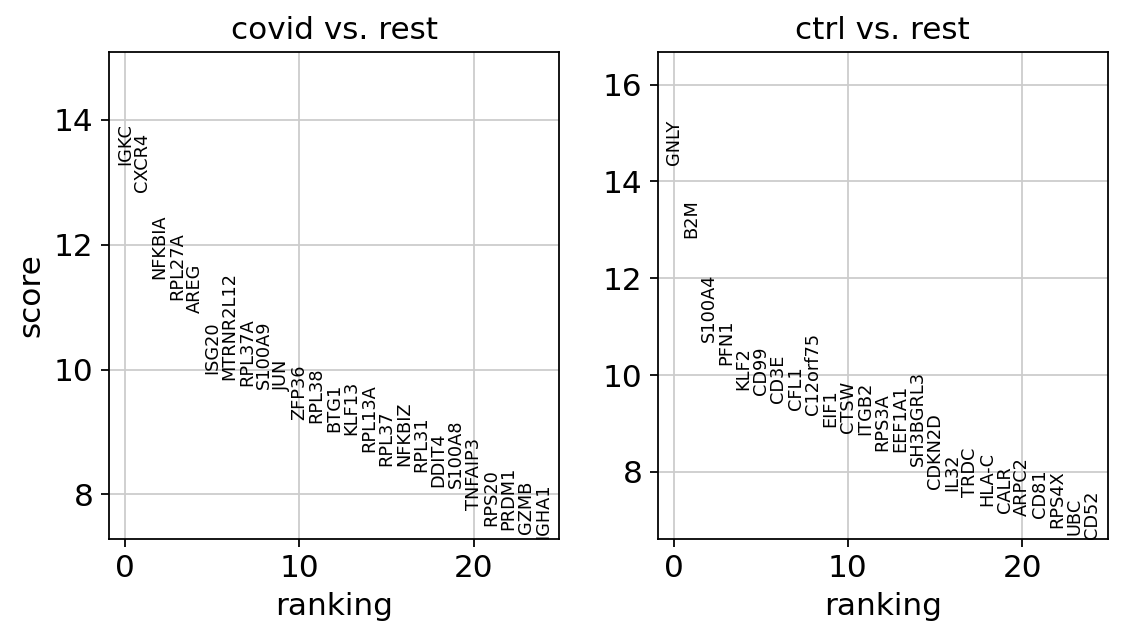

In [79]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

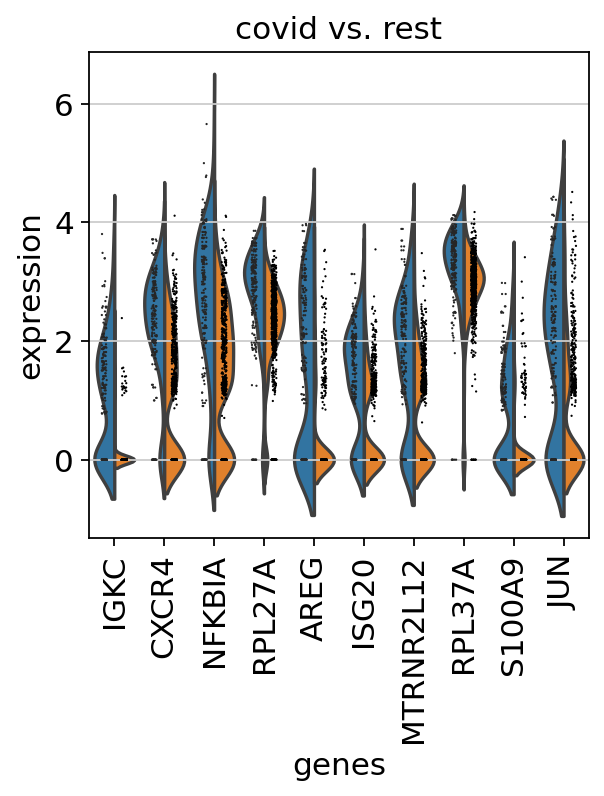

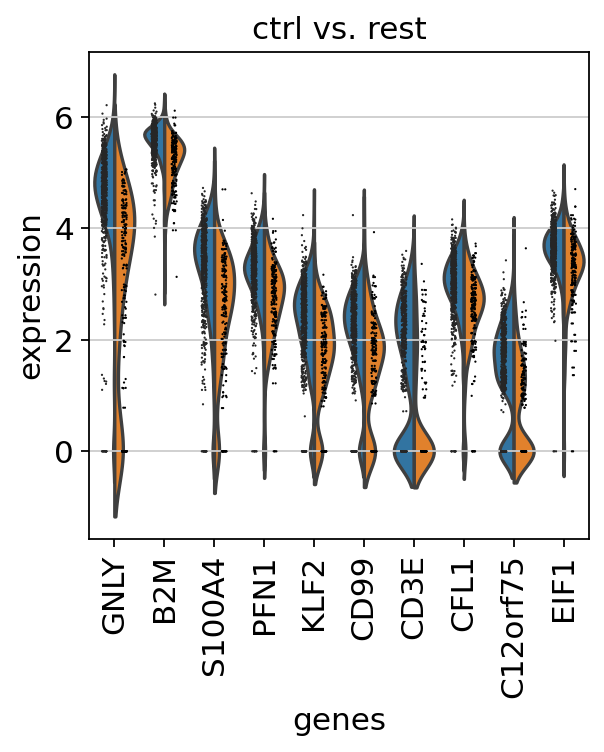

In [80]:
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")